# Modèles prédictifs du nombre de vélibs le week-end du 4 janvier 2021 au 12 février 2021

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import prettytable as ptbl
from prettytable import PrettyTable

In [95]:
velib = pd.read_csv(r"/Users/Romain/Documents/Romain/ENSAE 2A 2020-2021/Stat'App/Github Stat'App/velib_nombre.csv")
velib = velib.drop(['Unnamed: 0'], axis = 1)
velib

,10/19/20;18:56:54,10/19/20;19:56:58,10/19/20;20:57:02,10/19/20;21:57:05,10/19/20;22:57:14,10/19/20;23:57:18,10/20/20;00:57:22,10/20/20;01:57:26,10/20/20;02:57:30,10/20/20;03:57:34,...,02/15/21;11:49:48,02/15/21;12:53:25,02/15/21;13:56:59,02/15/21;15:00:34,02/15/21;16:04:08,02/15/21;17:07:43,02/15/21;18:11:18,02/15/21;19:16:38,02/15/21;20:20:06,02/15/21;21:23:35
0,1,2,5,4,3,3,3,3,2,2,...,2,2,2,1,2,4,2,5,3,4
1,45,48,49,51,52,52,52,52,52,45,...,37,37,39,41,40,38,32,25,24,24
2,2,3,10,9,11,9,9,9,9,9,...,1,1,0,4,4,1,1,4,5,3
3,6,9,10,12,10,10,11,11,11,11,...,6,5,8,8,5,4,6,4,5,8
4,7,16,25,24,23,24,24,24,24,24,...,6,3,4,2,2,4,6,11,17,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,15,25,27,31,32,33,33,32,32,33,...,22,21,21,19,21,23,30,34,36,36
1394,2,2,0,14,16,16,16,16,16,16,...,2,3,3,4,5,6,8,9,9,11
1395,6,15,29,34,35,35,35,35,35,35,...,8,8,13,9,8,7,10,22,25,29
1396,17,15,12,15,12,12,12,12,12,12,...,11,11,16,14,14,14,15,7,9,8


On dispose d'une base de données nettoyées avec un échantillonnage par heure sur toutes les stations Vélib d'Ile-de-France. 

Avant de commencer les analyses, on garde toutefois le numéro des stations ainsi que leurs informations : 

In [96]:
# Import des librairies pour importer les données open data au format Json
import urllib.request
import json
from pandas.io.json import json_normalize

In [97]:
request= urllib.request.Request('https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json')
response = urllib.request.urlopen(request)
station_info = response.read()
data = json.loads(station_info)
df_station_info = json_normalize(data['data']['stations'])
df_station_info.head()

,station_id,name,lat,lon,capacity,stationCode,rental_methods
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
1,99950133,André Mazet - Saint-André des Arts,48.853756,2.339096,55,6015,[CREDITCARD]
2,516709288,Charonne - Robert et Sonia Delauney,48.855908,2.392571,20,11104,NaN
3,36255,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
4,37815204,Mairie du 12ème,48.840855,2.387555,30,12109,NaN


In [98]:
df_id_name_capacity = df_station_info[["station_id", "lat", "lon", "name", "capacity"]]
velib_details = df_id_name_capacity.merge(velib, how = "inner", left_index=True, right_index=True)
#velib_w_capacity = velib_w_capacity[velib_w_capacity["capacity"] != 0]

In [99]:
velib_details[:10]

,station_id,lat,lon,name,capacity,10/19/20;18:56:54,10/19/20;19:56:58,10/19/20;20:57:02,10/19/20;21:57:05,10/19/20;22:57:14,...,02/15/21;11:49:48,02/15/21;12:53:25,02/15/21;13:56:59,02/15/21;15:00:34,02/15/21;16:04:08,02/15/21;17:07:43,02/15/21;18:11:18,02/15/21;19:16:38,02/15/21;20:20:06,02/15/21;21:23:35
0,213688169,48.865983,2.275725,Benjamin Godard - Victor Hugo,35,1,2,5,4,3,...,2,2,2,1,2,4,2,5,3,4
1,99950133,48.853756,2.339096,André Mazet - Saint-André des Arts,55,45,48,49,51,52,...,37,37,39,41,40,38,32,25,24,24
2,516709288,48.855908,2.392571,Charonne - Robert et Sonia Delauney,20,2,3,10,9,11,...,1,1,0,4,4,1,1,4,5,3
3,36255,48.879296,2.337360,Toudouze - Clauzel,21,6,9,10,12,10,...,6,5,8,8,5,4,6,4,5,8
4,37815204,48.840855,2.387555,Mairie du 12ème,30,7,16,25,24,23,...,6,3,4,2,2,4,6,11,17,18
5,100769544,48.851519,2.343670,Harpe - Saint-Germain,46,38,26,18,20,24,...,26,25,29,26,27,27,28,28,28,29
6,85002689,48.819428,2.343335,Jourdan - Stade Charléty,60,19,23,19,29,30,...,6,11,11,10,10,9,11,17,18,20
7,54000559,48.881973,2.301132,Jouffroy d'Abbans - Wagram,40,9,8,5,7,7,...,13,13,15,10,10,10,17,17,15,15
8,85043758,48.882878,2.287667,Guersant - Gouvion-Saint-Cyr,29,4,10,11,14,14,...,29,27,29,28,30,31,35,37,38,38
9,123095125,48.871044,2.366104,Alibert - Jemmapes,60,13,25,37,36,36,...,25,22,18,13,14,13,21,26,28,33


In [100]:
df_velib = velib.transpose()
df_velib

,0,1,2,3,4,5,6,7,8,9,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
10/19/20;18:56:54,1,45,2,6,7,38,19,9,4,13,...,6,4,2,38,18,15,2,6,17,17
10/19/20;19:56:58,2,48,3,9,16,26,23,8,10,25,...,7,6,1,21,20,25,2,15,15,13
10/19/20;20:57:02,5,49,10,10,25,18,19,5,11,37,...,5,12,1,18,17,27,0,29,12,5
10/19/20;21:57:05,4,51,9,12,24,20,29,7,14,36,...,6,14,2,17,19,31,14,34,15,6
10/19/20;22:57:14,3,52,11,10,23,24,30,7,14,36,...,6,13,0,18,19,32,16,35,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/15/21;17:07:43,4,38,1,4,4,27,9,10,31,13,...,3,10,2,15,11,23,6,7,14,22
02/15/21;18:11:18,2,32,1,6,6,28,11,17,35,21,...,5,11,2,11,11,30,8,10,15,11
02/15/21;19:16:38,5,25,4,4,11,28,17,17,37,26,...,11,16,3,11,12,34,9,22,7,6
02/15/21;20:20:06,3,24,5,5,17,28,18,15,38,28,...,10,18,1,13,12,36,9,25,9,5


In [101]:
def get_week_day_and_weekend_day(liste_dates_float):
    """
    Fonction qui prend en entrée les index du dataframe, c'est-à-dire la date en format string
    liste_dates_float : les index/dates du dataframe en string
    ___________________________________________________________________________________________

    Renvoie :
    liste_week_day : les index du dataframe pour les jours de la semaine (du lundi au jeudi)
    liste_weekend_day : les index du dataframe pour les jours du week-end (le samedi)
    ___________________________________________________________________________________________
    """
    liste_week_day = []
    liste_weekend_day = []
    for i in range(len(liste_dates_float)):
        jour = int(liste_dates_float[i][3]+liste_dates_float[i][4])
        mois = int(liste_dates_float[i][0]+liste_dates_float[i][1])
        annee = int('20'+liste_dates_float[i][6]+liste_dates_float[i][7])
        jour_de_la_semaine = date(annee, mois, jour).isoweekday()

        if jour_de_la_semaine in [1,2,3,4]:
            liste_week_day.append(liste_dates_float[i])

        if jour_de_la_semaine == 6:
            liste_weekend_day.append(liste_dates_float[i])

    return liste_week_day, liste_weekend_day

In [102]:
tous_les_axis = df_velib.index
liste_tous_les_axis = tous_les_axis.to_list()
liste_week_day, liste_weekend_day = get_week_day_and_weekend_day(liste_tous_les_axis)

# On extrait nos 2 sous-dataframes qui contiennent les données en semaine et un autre pour le week-end
df_week = df_velib.loc[liste_week_day, :]
df_weekend = df_velib.loc[liste_weekend_day, :]

# Machine Learning pour les prédictions le week-end

## Réalisation d'un apprentissage pour 10 stations aléatoires (les premières dans l'ordre des données) le week-end : automatisation

In [103]:
# Liste des stations cibles
stations_tests = []
for i in range(10):
    stations_tests.append("station_"+str(i))
stations_tests

['station_0',
 'station_1',
 'station_2',
 'station_3',
 'station_4',
 'station_5',
 'station_6',
 'station_7',
 'station_8',
 'station_9']

## Visualisation des données sélectionnées

In [104]:
import folium

# Titre : 
loc = 'Les 10 stations Velib selectionnees'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

stations_velib_paris = folium.Map(location = [48.856578, 2.351828], zoom_start = 12.5) # On centre sur Paris
for i in range(10): # Affichage des 10 premières stations considérées
    
    test_mark  = '<head><meta http-equiv="Content-Type" content="text/html; charset=windows-1252"></head>'
    test_mark += '<strong>'+stations_tests[i] + " " + df_station_info['name'][i] + ". Capacite = "+str(velib_details['capacity'][i])+'<strong>'

    folium.Marker(
        np.array([df_station_info['lat'][i],df_station_info['lon'][i]]).tolist(),
        #popup = stations_tests[i] + " " + df_station_info['name'][i] + ". Capacite = "+str(velib_details['capacity'][i]), 
        popup = test_mark, 
        icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(stations_velib_paris)

stations_velib_paris.get_root().html.add_child(folium.Element(title_html))

stations_velib_paris

## Machine Learning le week-end 

On considère aux 30 stations features les plus corrélées avec la station cible 

In [105]:
def choix_stations_correlees(df, n, num_station_target):
    """
    Renvoie une liste des n stations les plus corrélées à la station target
    df : dataframe utilisé pour le ML, i.e. les stations en colonne et la variable target 'y' correspondant au nombre de vélibs 24h plus tard
    n : nombre de features désiré
    num_station_target : numéro de la station définie comme target
    """
    matrice = abs(df.corr())
    candidats = matrice.nlargest(n+1,'y',keep='first')
    candidats.drop('y',0, inplace = True)
    features = list(candidats.index)
    # Rajout de la station target si elle ne fait pas partie des stations corrélées
    if num_station_target in features:
        pass
    else:
        features.append(num_station_target)
    return features

In [106]:
tous_les_axis = df_velib.index
liste_tous_les_axis = tous_les_axis.to_list()
axis_weekend_day = df_weekend.index

# Préparation des résultats à stocker : pour chaque station, on garde le numéro de la station dans le dataframe df_velib, le modèle de 
# régression linéaire et de random forest
resultats_choix_features_weekend = {}

# Préparation de la visualisation des résultats :
ptbl_weekend = PrettyTable()
ptbl_weekend.field_names = ["Station target", "Mean(Occupation) - weekend", "Std(Occupation) - weekend", "MAE LR - weekend", "MAE RF - weekend", "MAE méthode intuitive - weekend"]

# Machine Learning sur les 10 stations
for i in range(len(stations_tests)):

    # Dataframe pour la Régression Linéaire et le Random Forest
    df = df_weekend.copy()
    df['y'] = 0
    for j in range(len(df)):
        try:
            reperage_index = liste_tous_les_axis.index(axis_weekend_day[j])
            df['y'][axis_weekend_day[j]] = df_velib[i][tous_les_axis[reperage_index+24]]
        except (IndexError, KeyError) as e:
            df.drop(axis_weekend_day[j],0,inplace=True)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df,30,i)

    # Machine Learning
    X = df[features]
    # Préparation de la target
    y = df['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    #max_depth_opt, n_estimators_opt = parametres_rf_boost(X_train, y_train)
    #rf = RandomForestRegressor(max_depth = max_depth_opt, n_estimators = n_estimators_opt)
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[i], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[i].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[i].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[i])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_choix_features_weekend[stations_tests[i]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_weekend.add_row([stations_tests[i], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_weekend)
print("Résultats des MAE sur le test le week-end")

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - weekend | Std(Occupation) - weekend | MAE LR - weekend | MAE RF - weekend | MAE méthode intuitive - weekend |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            6.38            |            4.67           |       2.6        |       2.15       |               3.66              |
|   station_1    |           37.82            |           12.11           |       7.05       |      10.13       |               12.6              |
|   station_2    |            4.92            |            2.52           |       2.75       |       2.72       |               2.37              |
|   station_3    |            6.35            |            3.69           |       2.63       |       2.28       

On s'intéresse à présent à la moyenne des erreurs de prédiction des modèles : la moyenne des MAE

In [107]:
ptbl2_weekend = PrettyTable()
#ptbl.field_names = ["Occupation moyenne des stations cibles", "Moyenne MAE LR", "Moyenne MAE RF", "Moyenne MAE méthode naïve"]
ptbl2_weekend.field_names = ["Mean(Occupation)-weekend", "Std(Occupation)-weekend","Mean(MAE) LR - 1 modèle - weekend", "Mean(MAE) RF - 1 modèle - weekend", "Mean(MAE) naïf-weekend"]

mean_occupation1_weekend = 0
mean_std_occupation1_weekend = 0
mean_MAE_lr_weekend = 0
mean_MAE_rf_weekend = 0
mean_MAE_naif_weekend = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_choix_features_weekend.items():
    mean_occupation1_weekend += resultats_choix_features_weekend[key][9]
    mean_std_occupation1_weekend += resultats_choix_features_weekend[key][15]
    mean_MAE_lr_weekend += resultats_choix_features_weekend[key][4]
    mean_MAE_rf_weekend += resultats_choix_features_weekend[key][6]
    mean_MAE_naif_weekend += resultats_choix_features_weekend[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_occupation1_weekend = round(mean_occupation1_weekend/len(resultats_choix_features_weekend),2)
mean_std_occupation1_weekend = round(mean_std_occupation1_weekend/len(resultats_choix_features_weekend),2)
mean_MAE_lr_weekend = round(mean_MAE_lr_weekend/len(resultats_choix_features_weekend),2)
mean_MAE_rf_weekend = round(mean_MAE_rf_weekend/len(resultats_choix_features_weekend),2)
mean_MAE_naif_weekend = round(mean_MAE_naif_weekend/len(resultats_choix_features_weekend),2)

# Visualisation des performances avec Prettytable
ptbl2_weekend.add_row([mean_occupation1_weekend, mean_std_occupation1_weekend, mean_MAE_lr_weekend, mean_MAE_rf_weekend, mean_MAE_naif_weekend])
print(ptbl2_weekend)

+--------------------------+-------------------------+-----------------------------------+-----------------------------------+------------------------+
| Mean(Occupation)-weekend | Std(Occupation)-weekend | Mean(MAE) LR - 1 modèle - weekend | Mean(MAE) RF - 1 modèle - weekend | Mean(MAE) naïf-weekend |
+--------------------------+-------------------------+-----------------------------------+-----------------------------------+------------------------+
|          17.99           |           7.38          |                5.12               |                5.34               |          5.72          |
+--------------------------+-------------------------+-----------------------------------+-----------------------------------+------------------------+


**On regarde vite fait les stations target**

In [108]:
def ajout_categorie(df):
    """
    Ajoute une colonne 'categorie' à un dataframe utilisé pour le machine learning. 
    Les valeurs sont des strings : ou bien 'train' ou bien 'test'
    """
    df['categorie'] = 0
    df_index = df.index
    separation = np.floor(0.7*len(df))

    for i in range(len(df)):
        if i <= separation:
            df['categorie'][df_index[i]] = 'train'
        else:
            df['categorie'][df_index[i]] = 'test'

In [109]:
def ajout_numero(numero,df):
    """
    Ajoute le numéro de la station target
    """
    df['num_station_target'] = 0
    df['num_station_target'] = str(numero)

In [110]:
les_dfs_weekend = []
for i in range(10):
    df_week_end = resultats_choix_features_weekend[stations_tests[i]][1][i].copy()
    df_week_end = pd.DataFrame(df_week_end)
    df_week_end['nb_velibs'] = 0
    df_week_end['nb_velibs'] = df_week_end[i]
    del df_week_end[i]
    ajout_categorie(df_week_end)
    ajout_numero(i,df_week_end)
    les_dfs_weekend.append(df_week_end)

tous_les_dfs_weekend = pd.concat(les_dfs_weekend)
tous_les_dfs_weekend

,nb_velibs,categorie,num_station_target
10/24/20;00:12:15,4,train,0
10/24/20;01:12:29,4,train,0
10/24/20;02:12:43,4,train,0
10/24/20;03:12:59,4,train,0
10/24/20;04:13:13,4,train,0
...,...,...,...
02/13/21;19:36:34,45,test,9
02/13/21;20:40:04,44,test,9
02/13/21;21:43:34,43,test,9
02/13/21;22:47:10,43,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

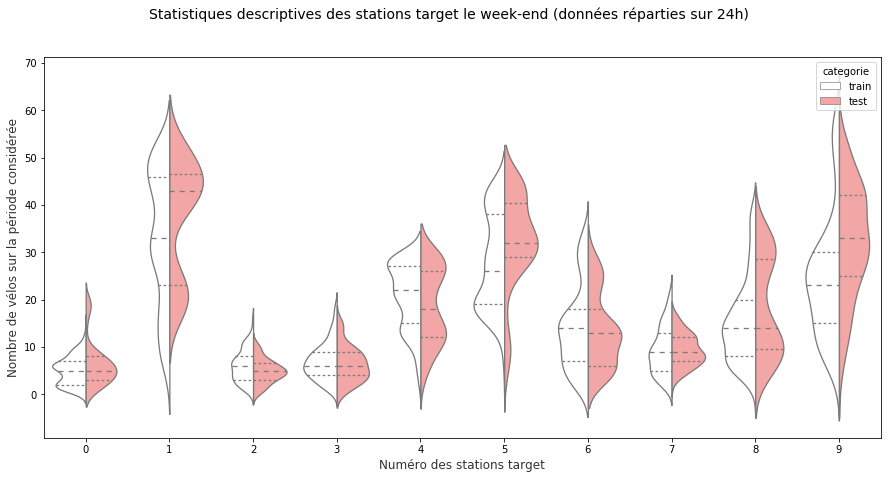

In [111]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target le week-end (données réparties sur 24h)', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs_weekend, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


On regarde ensuite à quelle heure de la journée est-ce que nous faisons le plus d'erreurs de prédiction.

## Moyenne des erreurs par heure le week-end

On rappelle que, pour la station i, 
- `resultats_choix_features_weekend[stations_tests[i]][10]` contient `y_test` du ML et colonne a le nom `y`
- `resultats_choix_features_weekend[stations_tests[i]][11]` contient les prédictions de `y_test` avec LR et colonne a le nom `0`
- `resultats_choix_features_weekend[stations_tests[i]][12]` contient les prédictions de `y_test` avec LR et colonne a le nom `0`
- `resultats_choix_features_weekend[stations_tests[i]][13]` contient `y_test` de la méthode naïve et colonne a le nom `i`
- `resultats_choix_features_weekend[stations_tests[i]][14]` contient les prédictions de `y_test` avec méthode naïve et colonne a le nom `y`

Fonction qui indique l'heure du pointage dans une nouvelle colonne `heure`

In [112]:
def get_heure(df):
    df['heure'] = df.index 
    for i in df.index:
        df['heure'][i] = float(df['heure'][i][9]+df['heure'][i][10])

On applique à présent cette fonction sur tous les dataframes des tests :

In [113]:
for i in stations_tests:
    get_heure(resultats_choix_features_weekend[i][10])
    get_heure(resultats_choix_features_weekend[i][11])
    get_heure(resultats_choix_features_weekend[i][12])
    get_heure(resultats_choix_features_weekend[i][13])
    get_heure(resultats_choix_features_weekend[i][14])

for i in range(len(stations_tests)):
    # Initialisation
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_lr'] = 0
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_rf'] = 0
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_naif'] = 0
    # On stocke les erreurs en valeur absolue
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_lr'] = abs(resultats_choix_features_weekend[stations_tests[i]][11][0] - resultats_choix_features_weekend[stations_tests[i]][10]['y'])
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_rf'] = abs(resultats_choix_features_weekend[stations_tests[i]][12][0] - resultats_choix_features_weekend[stations_tests[i]][10]['y'])
    resultats_choix_features_weekend[stations_tests[i]][10]['erreur_pred_naif'] = abs(resultats_choix_features_weekend[stations_tests[i]][13][i] - resultats_choix_features_weekend[stations_tests[i]][14]['y'])

# Initialisation
df_pred_errors_choix_features_weekend = resultats_choix_features_weekend[stations_tests[0]][10]

# On crée le dataframe de toutes les erreurs de prédictions en semaine pour les différents modèles sur les 10 stations
for i in stations_tests[1:]:
    df_pred_errors_choix_features_weekend = pd.concat([df_pred_errors_choix_features_weekend, resultats_choix_features_weekend[i][10]])

mean_erreur_par_heure_choix_features_weekend = df_pred_errors_choix_features_weekend.groupby('heure').mean()

In [114]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_lr'],
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_rf'],
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"     
))


fig.update_layout(
    title="Moyenne des erreurs de prédiction par heure le week-end sur 10 stations avec sélection de 30 features",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

## Machine Learning sur les périodes choisies

In [115]:
df_weekend

,0,1,2,3,4,5,6,7,8,9,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
10/24/20;00:12:15,4,19,8,7,28,19,9,16,14,17,...,10,22,2,4,10,30,12,24,20,12
10/24/20;01:12:29,4,18,8,7,28,19,11,16,14,17,...,10,22,3,4,10,30,12,24,20,12
10/24/20;02:12:43,4,18,8,7,28,18,11,16,14,17,...,12,22,1,3,10,30,12,25,20,12
10/24/20;03:12:59,4,17,8,8,29,18,11,15,13,18,...,12,22,1,4,10,30,12,26,20,12
10/24/20;04:13:13,4,17,8,7,29,18,11,14,13,18,...,11,22,1,4,10,31,12,26,20,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/13/21;19:36:34,3,27,1,9,22,35,5,8,30,45,...,1,14,4,7,14,22,2,39,19,10
02/13/21;20:40:04,3,23,2,7,22,38,3,7,30,44,...,1,14,4,9,14,22,3,39,19,11
02/13/21;21:43:34,3,23,5,3,22,43,3,7,29,43,...,3,14,3,9,15,22,4,36,20,11
02/13/21;22:47:10,3,24,5,1,22,42,4,6,28,43,...,3,14,4,9,15,22,4,28,19,11


In [116]:
df_h = df_weekend.copy()
df_h['heure'] = df_weekend.index
df_h.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/24/20;00:12:15,4,19,8,7,28,19,9,16,14,17,...,22,2,4,10,30,12,24,20,12,10/24/20;00:12:15
10/24/20;01:12:29,4,18,8,7,28,19,11,16,14,17,...,22,3,4,10,30,12,24,20,12,10/24/20;01:12:29
10/24/20;02:12:43,4,18,8,7,28,18,11,16,14,17,...,22,1,3,10,30,12,25,20,12,10/24/20;02:12:43
10/24/20;03:12:59,4,17,8,8,29,18,11,15,13,18,...,22,1,4,10,30,12,26,20,12,10/24/20;03:12:59
10/24/20;04:13:13,4,17,8,7,29,18,11,14,13,18,...,22,1,4,10,31,12,26,20,12,10/24/20;04:13:13


In [117]:
# On ne garde que les heures dans la date
for i in range(len(df_h)):
    df_h['heure'][i] = int(df_h['heure'][i][9]+df_h['heure'][i][10])

df_h.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,heure
10/24/20;00:12:15,4,19,8,7,28,19,9,16,14,17,...,22,2,4,10,30,12,24,20,12,0
10/24/20;01:12:29,4,18,8,7,28,19,11,16,14,17,...,22,3,4,10,30,12,24,20,12,1
10/24/20;02:12:43,4,18,8,7,28,18,11,16,14,17,...,22,1,3,10,30,12,25,20,12,2
10/24/20;03:12:59,4,17,8,8,29,18,11,15,13,18,...,22,1,4,10,30,12,26,20,12,3
10/24/20;04:13:13,4,17,8,7,29,18,11,14,13,18,...,22,1,4,10,31,12,26,20,12,4


# Modèles prédictifs le week-end heure par heure

In [118]:
heures = np.linspace(0,23,24)
heures_jour = np.linspace(6,18,13)

In [119]:
def sous_df_1h(df, h):
    """
    Renvoie le sous dataframe avec l'heure target

    h : l'heure target
    df : le dataframe court sur la période choisie par Malo
    """
    pas_les_bonnes_heures = list(np.linspace(0,23,24))
    pas_les_bonnes_heures.remove(h)
    df_c = df.copy()
    test = df_c.isin({'heure': pas_les_bonnes_heures})

    for i in df_c.index:
        if test['heure'][i] == True:
            df_c.drop(i,0,inplace = True)

    # Et on supprime la colonne des heures
    del df_c['heure']

    return df_c

In [120]:
testtt = sous_df_1h(df_h,0)
testtt

,0,1,2,3,4,5,6,7,8,9,...,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397
10/24/20;00:12:15,4,19,8,7,28,19,9,16,14,17,...,10,22,2,4,10,30,12,24,20,12
10/31/20;00:12:27,6,29,12,1,26,26,34,4,7,30,...,13,21,2,21,9,29,6,23,15,13
11/07/20;00:20:32,6,16,5,5,21,21,28,10,13,31,...,16,13,1,10,18,27,10,33,16,3
11/14/20;00:53:18,7,32,11,12,28,18,20,18,38,51,...,19,18,1,16,27,36,16,38,14,4
11/21/20;00:53:37,3,32,5,6,23,16,15,4,25,25,...,11,23,2,17,19,38,6,27,10,19
11/28/20;00:14:41,12,11,8,10,26,18,24,9,17,26,...,9,22,5,12,35,35,9,14,7,5
12/05/20;00:16:57,9,39,7,4,22,39,5,2,13,9,...,4,14,5,27,22,23,5,22,6,4
12/12/20;00:54:12,4,49,7,6,21,44,7,9,15,27,...,6,19,2,12,29,33,6,3,9,3
12/19/20;00:06:24,7,51,10,9,29,28,16,14,13,23,...,13,9,4,13,35,24,3,31,11,5
12/26/20;00:01:56,6,42,7,8,23,30,14,4,10,9,...,1,7,0,8,31,23,13,12,20,6


In [121]:
def sous_df_ml(df_1h, num_station):
    """
    Renvoie le dataframe avec la variable target 'y' : PRÉPARATION AU ML

    num_station : le numéro de la station cible
    df : le sous_df
    """    
    axis = df_1h.index
    df_c = df_1h.copy()
    df_c['y'] = df_c[num_station]

    for j in range(len(df_c)):
        try:
            reperage_index = liste_tous_les_axis.index(axis[j])
            df_c['y'][axis[j]] = df_velib[num_station][tous_les_axis[reperage_index+24]]
        except (IndexError, KeyError) as e:
            df_c.drop(axis[j],0,inplace=True)

    return df_c

In [122]:
sous_df_ml(testtt, 0)

,0,1,2,3,4,5,6,7,8,9,...,1389,1390,1391,1392,1393,1394,1395,1396,1397,y
10/24/20;00:12:15,4,19,8,7,28,19,9,16,14,17,...,22,2,4,10,30,12,24,20,12,2
10/31/20;00:12:27,6,29,12,1,26,26,34,4,7,30,...,21,2,21,9,29,6,23,15,13,4
11/07/20;00:20:32,6,16,5,5,21,21,28,10,13,31,...,13,1,10,18,27,10,33,16,3,1
11/14/20;00:53:18,7,32,11,12,28,18,20,18,38,51,...,18,1,16,27,36,16,38,14,4,5
11/21/20;00:53:37,3,32,5,6,23,16,15,4,25,25,...,23,2,17,19,38,6,27,10,19,10
11/28/20;00:14:41,12,11,8,10,26,18,24,9,17,26,...,22,5,12,35,35,9,14,7,5,6
12/05/20;00:16:57,9,39,7,4,22,39,5,2,13,9,...,14,5,27,22,23,5,22,6,4,3
12/12/20;00:54:12,4,49,7,6,21,44,7,9,15,27,...,19,2,12,29,33,6,3,9,3,1
12/19/20;00:06:24,7,51,10,9,29,28,16,14,13,23,...,9,4,13,35,24,3,31,11,5,3
12/26/20;00:01:56,6,42,7,8,23,30,14,4,10,9,...,7,0,8,31,23,13,12,20,6,1


# Résultats 0h-0h59

In [123]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_0h = {}
# Préparation de la visualisation des résultats :
ptbl_0h = PrettyTable()
ptbl_0h.field_names = ["Station target", "Mean(Occupation) - 0h-0h59", "Std(Occupation) - 0h-0h59", "MAE LR - 0h-0h59", "MAE RF - 0h-0h59", "MAE méthode intuitive - 0h-0h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 0h
    df_1h = sous_df_1h(df_h,0)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_0h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_0h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_0h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 0h-0h59 | Std(Occupation) - 0h-0h59 | MAE LR - 0h-0h59 | MAE RF - 0h-0h59 | MAE méthode intuitive - 0h-0h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.67            |            5.47           |       0.65       |       1.75       |               4.83              |
|   station_1    |           33.67            |           11.02           |       6.12       |       6.82       |               8.67              |
|   station_2    |            4.83            |            2.79           |       0.29       |       1.45       |               1.5               |
|   station_3    |            8.33            |            2.42           |       1.53       |       1.15       

In [124]:
les_dfs_0h = []
for i in range(10):
    df = resultats_0h[stations_tests[i]][1][i].copy()
    df = pd.DataFrame(df)
    df['nb_velibs'] = 0
    df['nb_velibs'] = df[i]
    del df[i]
    ajout_categorie(df)
    ajout_numero(i,df)
    les_dfs_0h.append(df)

tous_les_dfs_0h = pd.concat(les_dfs_0h)
tous_les_dfs_0h

,nb_velibs,categorie,num_station_target
10/24/20;00:12:15,4,train,0
10/31/20;00:12:27,6,train,0
11/07/20;00:20:32,6,train,0
11/14/20;00:53:18,7,train,0
11/21/20;00:53:37,3,train,0
...,...,...,...
01/16/21;00:49:41,27,test,9
01/23/21;00:31:28,41,test,9
01/30/21;00:22:23,34,test,9
02/06/21;00:44:12,40,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

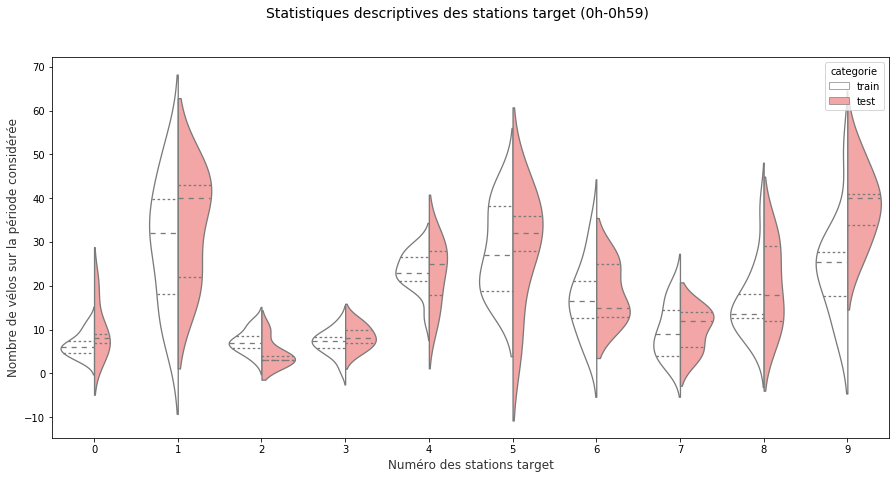

In [125]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target (0h-0h59)', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs_0h, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


In [126]:
ptbl_0h_sum = PrettyTable()
ptbl_0h_sum.field_names = ["Mean(Occupation) / 0h-0h59", "Mean(Std(Occupation)) / 0h-0h59", "Mean MAE LR / 0h-0h59", "Mean MAE RF / 0h-0h59", "Mean MAE méthode naïve / 0h-0h59"]
mean_capacity_0h = 0
mean_std_occupation_0h = 0
mean_MAE_lr_0h = 0
mean_MAE_rf_0h = 0
mean_MAE_naif_0h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_0h.items():
    mean_capacity_0h += resultats_0h[key][9]
    mean_std_occupation_0h += resultats_0h[key][15]
    mean_MAE_lr_0h += resultats_0h[key][4]
    mean_MAE_rf_0h += resultats_0h[key][6]
    mean_MAE_naif_0h += resultats_0h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_0h = round(mean_capacity_0h/len(resultats_0h),2)
mean_std_occupation_0h = round(mean_std_occupation_0h/len(resultats_0h),2)
mean_MAE_lr_0h = round(mean_MAE_lr_0h/len(resultats_0h),2)
mean_MAE_rf_0h = round(mean_MAE_rf_0h/len(resultats_0h),2)
mean_MAE_naif_0h = round(mean_MAE_naif_0h/len(resultats_0h),2)

# Visualisation des performances avec Prettytable
ptbl_0h_sum.add_row([mean_capacity_0h, mean_std_occupation_0h, mean_MAE_lr_0h, mean_MAE_rf_0h, mean_MAE_naif_0h])
print(ptbl_0h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 0h-0h59 | Mean(Std(Occupation)) / 0h-0h59 | Mean MAE LR / 0h-0h59 | Mean MAE RF / 0h-0h59 | Mean MAE méthode naïve / 0h-0h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           19.12            |               7.13              |          2.81         |          3.36         |               5.98               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats 1h-1h59

In [127]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_1h = {}
# Préparation de la visualisation des résultats :
ptbl_1h = PrettyTable()
ptbl_1h.field_names = ["Station target", "Mean(Occupation) - 1h-1h59", "Std(Occupation) - 1h-1h59", "MAE LR - 1h-1h59", "MAE RF - 1h-1h59", "MAE méthode intuitive - 1h-1h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 1h
    df_1h = sous_df_1h(df_h,1)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_1h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_1h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_1h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 1h-1h59 | Std(Occupation) - 1h-1h59 | MAE LR - 1h-1h59 | MAE RF - 1h-1h59 | MAE méthode intuitive - 1h-1h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.67            |            4.84           |       0.94       |       1.33       |               4.83              |
|   station_1    |           33.33            |           10.84           |       5.54       |       7.37       |               12.0              |
|   station_2    |            5.33            |            2.66           |       1.68       |       0.98       |               1.83              |
|   station_3    |            7.5             |            3.27           |       0.89       |       2.35       

In [128]:
ptbl_1h_sum = PrettyTable()
ptbl_1h_sum.field_names = ["Mean(Occupation) / 1h-1h59", "Mean(Std(Occupation)) / 1h-1h59", "Mean MAE LR / 1h-1h59", "Mean MAE RF / 1h-1h59", "Mean MAE méthode naïve / 1h-1h59"]
mean_capacity_1h = 0
mean_std_occupation_1h = 0
mean_MAE_lr_1h = 0
mean_MAE_rf_1h = 0
mean_MAE_naif_1h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_1h.items():
    mean_capacity_1h += resultats_1h[key][9]
    mean_std_occupation_1h += resultats_1h[key][15]
    mean_MAE_lr_1h += resultats_1h[key][4]
    mean_MAE_rf_1h += resultats_1h[key][6]
    mean_MAE_naif_1h += resultats_1h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_1h = round(mean_capacity_1h/len(resultats_1h),2)
mean_std_occupation_1h = round(mean_std_occupation_1h/len(resultats_1h),2)
mean_MAE_lr_1h = round(mean_MAE_lr_1h/len(resultats_1h),2)
mean_MAE_rf_1h = round(mean_MAE_rf_1h/len(resultats_1h),2)
mean_MAE_naif_1h = round(mean_MAE_naif_1h/len(resultats_1h),2)

# Visualisation des performances avec Prettytable
ptbl_1h_sum.add_row([mean_capacity_1h, mean_std_occupation_1h, mean_MAE_lr_1h, mean_MAE_rf_1h, mean_MAE_naif_1h])
print(ptbl_1h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 1h-1h59 | Mean(Std(Occupation)) / 1h-1h59 | Mean MAE LR / 1h-1h59 | Mean MAE RF / 1h-1h59 | Mean MAE méthode naïve / 1h-1h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           19.22            |               7.18              |          2.74         |          3.7          |               6.05               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


In [129]:
les_dfs_1h = []
for i in range(10):
    df = resultats_1h[stations_tests[i]][1][i].copy()
    df = pd.DataFrame(df)
    df['nb_velibs'] = 0
    df['nb_velibs'] = df[i]
    del df[i]
    ajout_categorie(df)
    ajout_numero(i,df)
    les_dfs_1h.append(df)

tous_les_dfs_1h = pd.concat(les_dfs_1h)
tous_les_dfs_1h

,nb_velibs,categorie,num_station_target
10/24/20;01:12:29,4,train,0
10/31/20;01:12:44,6,train,0
11/07/20;01:20:59,6,train,0
11/14/20;01:53:56,8,train,0
11/21/20;01:54:25,1,train,0
...,...,...,...
01/16/21;01:52:13,30,test,9
01/23/21;01:34:23,43,test,9
01/30/21;01:25:23,32,test,9
02/06/21;01:47:23,39,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

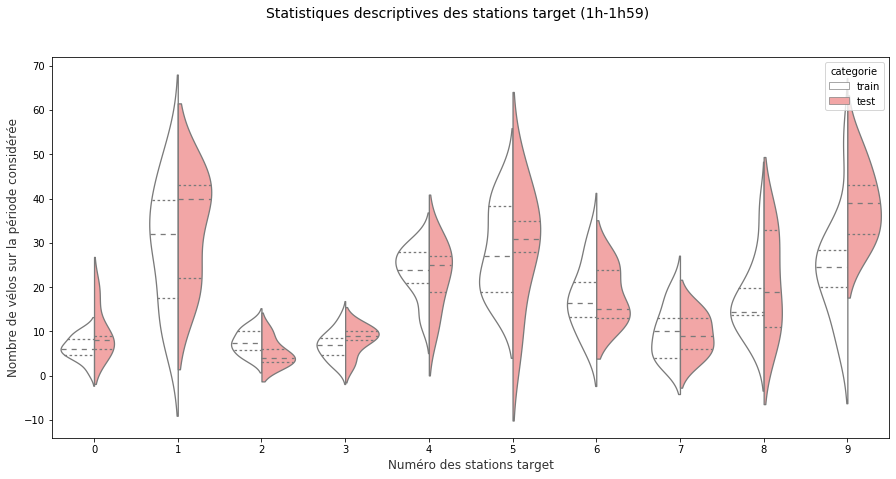

In [130]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target (1h-1h59)', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs_1h, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


# Résultats 2h-2h59

In [131]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_2h = {}
# Préparation de la visualisation des résultats :
ptbl_2h = PrettyTable()
ptbl_2h.field_names = ["Station target", "Mean(Occupation) - 2h-2h59", "Std(Occupation) - 2h-2h59", "MAE LR - 2h-2h59", "MAE RF - 2h-2h59", "MAE méthode intuitive - 2h-2h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 2h
    df_1h = sous_df_1h(df_h,2)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_2h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_2h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_2h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 2h-2h59 | Std(Occupation) - 2h-2h59 | MAE LR - 2h-2h59 | MAE RF - 2h-2h59 | MAE méthode intuitive - 2h-2h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.33            |            5.24           |       1.18       |       1.45       |               4.33              |
|   station_1    |            33.5            |           10.73           |       7.35       |      10.88       |              14.33              |
|   station_2    |            5.5             |            3.08           |       1.51       |       1.33       |               2.17              |
|   station_3    |            8.67            |            3.72           |       1.48       |       2.02       

In [132]:
ptbl_2h_sum = PrettyTable()
ptbl_2h_sum.field_names = ["Mean(Occupation) / 2h-2h59", "Mean(Std(Occupation)) / 2h-2h59", "Mean MAE LR / 2h-2h59", "Mean MAE RF / 2h-2h59", "Mean MAE méthode naïve / 2h-2h59"]
mean_capacity_2h = 0
mean_std_occupation_2h = 0
mean_MAE_lr_2h = 0
mean_MAE_rf_2h = 0
mean_MAE_naif_2h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_2h.items():
    mean_capacity_2h += resultats_2h[key][9]
    mean_std_occupation_2h += resultats_2h[key][15]
    mean_MAE_lr_2h += resultats_2h[key][4]
    mean_MAE_rf_2h += resultats_2h[key][6]
    mean_MAE_naif_2h += resultats_2h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_2h = round(mean_capacity_2h/len(resultats_2h),2)
mean_std_occupation_2h = round(mean_std_occupation_2h/len(resultats_2h),2)
mean_MAE_lr_2h = round(mean_MAE_lr_2h/len(resultats_2h),2)
mean_MAE_rf_2h = round(mean_MAE_rf_2h/len(resultats_2h),2)
mean_MAE_naif_2h = round(mean_MAE_naif_2h/len(resultats_2h),2)

# Visualisation des performances avec Prettytable
ptbl_2h_sum.add_row([mean_capacity_2h, mean_std_occupation_2h, mean_MAE_lr_2h, mean_MAE_rf_2h, mean_MAE_naif_2h])
print(ptbl_2h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 2h-2h59 | Mean(Std(Occupation)) / 2h-2h59 | Mean MAE LR / 2h-2h59 | Mean MAE RF / 2h-2h59 | Mean MAE méthode naïve / 2h-2h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           19.13            |               7.04              |          3.1          |          4.3          |               6.08               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats 3h-3h59

In [133]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_3h = {}
# Préparation de la visualisation des résultats :
ptbl_3h = PrettyTable()
ptbl_3h.field_names = ["Station target", "Mean(Occupation) - 3h-3h59", "Std(Occupation) - 3h-2h59", "MAE LR - 3h-3h59", "MAE RF - 3h-3h59", "MAE méthode intuitive - 3h-3h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 3h
    df_1h = sous_df_1h(df_h,3)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_3h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_3h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_3h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 3h-3h59 | Std(Occupation) - 3h-2h59 | MAE LR - 3h-3h59 | MAE RF - 3h-3h59 | MAE méthode intuitive - 3h-3h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.17            |            5.31           |       0.91       |       1.5        |               4.0               |
|   station_1    |           33.67            |           11.29           |       4.83       |      10.13       |              14.67              |
|   station_2    |            4.83            |            1.72           |       1.16       |       1.58       |               1.5               |
|   station_3    |            8.0             |            4.0            |       1.15       |       1.33       

In [134]:
ptbl_3h_sum = PrettyTable()
ptbl_3h_sum.field_names = ["Mean(Occupation) / 3h-3h59", "Mean(Std(Occupation)) / 3h-3h59", "Mean MAE LR / 3h-3h59", "Mean MAE RF / 3h-3h59", "Mean MAE méthode naïve / 3h-3h59"]
mean_capacity_3h = 0
mean_std_occupation_3h = 0
mean_MAE_lr_3h = 0
mean_MAE_rf_3h = 0
mean_MAE_naif_3h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_3h.items():
    mean_capacity_3h += resultats_3h[key][9]
    mean_std_occupation_3h += resultats_3h[key][15]
    mean_MAE_lr_3h += resultats_3h[key][4]
    mean_MAE_rf_3h += resultats_3h[key][6]
    mean_MAE_naif_3h += resultats_3h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_3h = round(mean_capacity_3h/len(resultats_3h),2)
mean_std_occupation_3h = round(mean_std_occupation_3h/len(resultats_3h),2)
mean_MAE_lr_3h = round(mean_MAE_lr_3h/len(resultats_3h),2)
mean_MAE_rf_3h = round(mean_MAE_rf_3h/len(resultats_3h),2)
mean_MAE_naif_3h = round(mean_MAE_naif_3h/len(resultats_3h),2)

# Visualisation des performances avec Prettytable
ptbl_3h_sum.add_row([mean_capacity_3h, mean_std_occupation_3h, mean_MAE_lr_3h, mean_MAE_rf_3h, mean_MAE_naif_3h])
print(ptbl_3h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 3h-3h59 | Mean(Std(Occupation)) / 3h-3h59 | Mean MAE LR / 3h-3h59 | Mean MAE RF / 3h-3h59 | Mean MAE méthode naïve / 3h-3h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.72            |               7.02              |          2.33         |          4.33         |               5.82               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats 4h-4h59

In [135]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_4h = {}
# Préparation de la visualisation des résultats :
ptbl_4h = PrettyTable()
ptbl_4h.field_names = ["Station target", "Mean(Occupation) - 4h-4h59", "Std(Occupation) - 4h-4h59", "MAE LR - 4h-4h59", "MAE RF - 4h-4h59", "MAE méthode intuitive - 4h-4h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 4h
    df_1h = sous_df_1h(df_h,4)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_4h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_4h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_4h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 4h-4h59 | Std(Occupation) - 4h-4h59 | MAE LR - 4h-4h59 | MAE RF - 4h-4h59 | MAE méthode intuitive - 4h-4h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            8.83            |            5.34           |       0.96       |       1.68       |               3.83              |
|   station_1    |            33.5            |           10.58           |       8.67       |      11.52       |              14.33              |
|   station_2    |            4.67            |            1.37           |       1.52       |       1.62       |               1.33              |
|   station_3    |            8.17            |            4.31           |       1.41       |       1.47       

In [136]:
ptbl_4h_sum = PrettyTable()
ptbl_4h_sum.field_names = ["Mean(Occupation) / 4h-4h59", "Mean(Std(Occupation)) / 4h-4h59", "Mean MAE LR / 4h-4h59", "Mean MAE RF / 4h-4h59", "Mean MAE méthode naïve / 4h-4h59"]
mean_capacity_4h = 0
mean_std_occupation_4h = 0
mean_MAE_lr_4h = 0
mean_MAE_rf_4h = 0
mean_MAE_naif_4h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_4h.items():
    mean_capacity_4h += resultats_4h[key][9]
    mean_std_occupation_4h += resultats_4h[key][15]
    mean_MAE_lr_4h += resultats_4h[key][4]
    mean_MAE_rf_4h += resultats_4h[key][6]
    mean_MAE_naif_4h += resultats_4h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_4h = round(mean_capacity_4h/len(resultats_4h),2)
mean_std_occupation_4h = round(mean_std_occupation_4h/len(resultats_4h),2)
mean_MAE_lr_4h = round(mean_MAE_lr_4h/len(resultats_4h),2)
mean_MAE_rf_4h = round(mean_MAE_rf_4h/len(resultats_4h),2)
mean_MAE_naif_4h = round(mean_MAE_naif_4h/len(resultats_4h),2)

# Visualisation des performances avec Prettytable
ptbl_4h_sum.add_row([mean_capacity_4h, mean_std_occupation_4h, mean_MAE_lr_4h, mean_MAE_rf_4h, mean_MAE_naif_4h])
print(ptbl_4h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 4h-4h59 | Mean(Std(Occupation)) / 4h-4h59 | Mean MAE LR / 4h-4h59 | Mean MAE RF / 4h-4h59 | Mean MAE méthode naïve / 4h-4h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.77            |               7.0               |          2.69         |          4.64         |               5.65               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats 5h-5h59

In [137]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_5h = {}
# Préparation de la visualisation des résultats :
ptbl_5h = PrettyTable()
ptbl_5h.field_names = ["Station target", "Mean(Occupation) - 5h-5h59", "Std(Occupation) - 5h-5h59", "MAE LR - 5h-5h59", "MAE RF - 5h-5h59", "MAE méthode intuitive - 5h-5h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 5h
    df_1h = sous_df_1h(df_h,5)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_5h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_5h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_5h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 5h-5h59 | Std(Occupation) - 5h-5h59 | MAE LR - 5h-5h59 | MAE RF - 5h-5h59 | MAE méthode intuitive - 5h-5h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.6             |            5.59           |       0.63       |       1.98       |               3.8               |
|   station_1    |            24.6            |           12.78           |       7.04       |       9.62       |               20.2              |
|   station_2    |            4.0             |            0.71           |       1.58       |       1.9        |               2.2               |
|   station_3    |            7.8             |            5.07           |       0.69       |       1.44       

In [138]:
ptbl_5h_sum = PrettyTable()
ptbl_5h_sum.field_names = ["Mean(Occupation) / 5h-5h59", "Mean(Std(Occupation)) / 5h-5h59", "Mean MAE LR / 5h-5h59", "Mean MAE RF / 5h-5h59", "Mean MAE méthode naïve / 5h-5h59"]
mean_capacity_5h = 0
mean_std_occupation_5h = 0
mean_MAE_lr_5h = 0
mean_MAE_rf_5h = 0
mean_MAE_naif_5h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_5h.items():
    mean_capacity_5h += resultats_5h[key][9]
    mean_std_occupation_5h += resultats_5h[key][15]
    mean_MAE_lr_5h += resultats_5h[key][4]
    mean_MAE_rf_5h += resultats_5h[key][6]
    mean_MAE_naif_5h += resultats_5h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_5h = round(mean_capacity_5h/len(resultats_5h),2)
mean_std_occupation_5h = round(mean_std_occupation_5h/len(resultats_5h),2)
mean_MAE_lr_5h = round(mean_MAE_lr_5h/len(resultats_5h),2)
mean_MAE_rf_5h = round(mean_MAE_rf_5h/len(resultats_5h),2)
mean_MAE_naif_5h = round(mean_MAE_naif_5h/len(resultats_5h),2)

# Visualisation des performances avec Prettytable
ptbl_5h_sum.add_row([mean_capacity_5h, mean_std_occupation_5h, mean_MAE_lr_5h, mean_MAE_rf_5h, mean_MAE_naif_5h])
print(ptbl_5h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 5h-5h59 | Mean(Std(Occupation)) / 5h-5h59 | Mean MAE LR / 5h-5h59 | Mean MAE RF / 5h-5h59 | Mean MAE méthode naïve / 5h-5h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.18            |               6.98              |          2.59         |          4.36         |               5.74               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 6h-6h59

In [139]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_6h = {}
# Préparation de la visualisation des résultats :
ptbl_6h = PrettyTable()
ptbl_6h.field_names = ["Station target", "Mean(Occupation) - 6h-6h59", "Std(Occupation) - 6h-6h59", "MAE LR - 6h-6h59", "MAE RF - 6h-6h59", "MAE méthode intuitive - 6h-6h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 6h
    df_1h = sous_df_1h(df_h,6)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_6h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_6h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_6h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 6h-6h59 | Std(Occupation) - 6h-6h59 | MAE LR - 6h-6h59 | MAE RF - 6h-6h59 | MAE méthode intuitive - 6h-6h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.17            |            5.12           |       1.11       |       1.63       |               3.83              |
|   station_1    |            33.5            |           11.22           |       6.2        |      10.45       |              14.17              |
|   station_2    |            4.5             |            1.97           |       0.98       |       1.58       |               1.67              |
|   station_3    |            8.5             |            3.94           |       0.95       |       1.23       

In [140]:
les_dfs_6h = []
for i in range(10):
    df = resultats_6h[stations_tests[i]][1][i].copy()
    df = pd.DataFrame(df)
    df['nb_velibs'] = 0
    df['nb_velibs'] = df[i]
    del df[i]
    ajout_categorie(df)
    ajout_numero(i,df)
    les_dfs_6h.append(df)

tous_les_dfs_6h = pd.concat(les_dfs_6h)
tous_les_dfs_6h

,nb_velibs,categorie,num_station_target
10/24/20;06:13:46,4,train,0
10/31/20;06:14:12,9,train,0
11/07/20;06:23:19,6,train,0
11/14/20;06:57:10,9,train,0
11/21/20;06:58:36,1,train,0
...,...,...,...
01/16/21;06:02:23,33,test,9
01/23/21;06:48:52,43,test,9
01/30/21;06:40:23,23,test,9
02/06/21;06:00:16,40,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

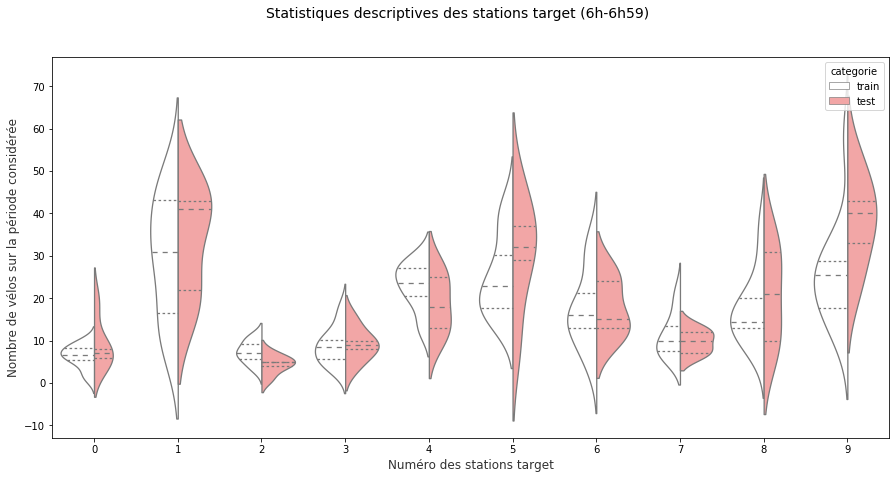

In [141]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target (6h-6h59)', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs_6h, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


In [142]:
ptbl_6h_sum = PrettyTable()
ptbl_6h_sum.field_names = ["Mean(Occupation) / 6h-6h59", "Mean(Std(Occupation)) / 6h-6h59", "Mean MAE LR / 6h-6h59", "Mean MAE RF / 6h-6h59", "Mean MAE méthode naïve / 6h-6h59"]
mean_capacity_6h = 0
mean_std_occupation_6h = 0
mean_MAE_lr_6h = 0
mean_MAE_rf_6h = 0
mean_MAE_naif_6h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_6h.items():
    mean_capacity_6h += resultats_6h[key][9]
    mean_std_occupation_6h += resultats_6h[key][15]
    mean_MAE_lr_6h += resultats_6h[key][4]
    mean_MAE_rf_6h += resultats_6h[key][6]
    mean_MAE_naif_6h += resultats_6h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_6h = round(mean_capacity_6h/len(resultats_6h),2)
mean_std_occupation_6h = round(mean_std_occupation_6h/len(resultats_6h),2)
mean_MAE_lr_6h = round(mean_MAE_lr_6h/len(resultats_6h),2)
mean_MAE_rf_6h = round(mean_MAE_rf_6h/len(resultats_6h),2)
mean_MAE_naif_6h = round(mean_MAE_naif_6h/len(resultats_6h),2)

# Visualisation des performances avec Prettytable
ptbl_6h_sum.add_row([mean_capacity_6h, mean_std_occupation_6h, mean_MAE_lr_6h, mean_MAE_rf_6h, mean_MAE_naif_6h])
print(ptbl_6h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 6h-6h59 | Mean(Std(Occupation)) / 6h-6h59 | Mean MAE LR / 6h-6h59 | Mean MAE RF / 6h-6h59 | Mean MAE méthode naïve / 6h-6h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.73            |               7.09              |          2.78         |          4.4          |               5.55               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 7h-7h59

In [143]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_7h = {}
# Préparation de la visualisation des résultats :
ptbl_7h = PrettyTable()
ptbl_7h.field_names = ["Station target", "Mean(Occupation) - 7h-7h59", "Std(Occupation) - 7h-7h59", "MAE LR - 7h-7h59", "MAE RF - 7h-7h59", "MAE méthode intuitive - 7h-7h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 7h
    df_1h = sous_df_1h(df_h,7)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_7h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_7h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_7h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 7h-7h59 | Std(Occupation) - 7h-7h59 | MAE LR - 7h-7h59 | MAE RF - 7h-7h59 | MAE méthode intuitive - 7h-7h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            9.17            |            5.12           |       0.88       |       2.32       |               3.67              |
|   station_1    |           33.33            |           11.83           |       5.44       |       9.92       |              14.67              |
|   station_2    |            4.5             |            2.66           |       1.42       |       0.93       |               1.83              |
|   station_3    |            8.0             |            4.1            |       1.01       |       1.35       

In [144]:
ptbl_7h_sum = PrettyTable()
ptbl_7h_sum.field_names = ["Mean(Occupation) / 7h-7h59", "Mean(Std(Occupation)) / 7h-7h59", "Mean MAE LR / 7h-7h59", "Mean MAE RF / 7h-7h59", "Mean MAE méthode naïve / 7h-7h59"]
mean_capacity_7h = 0
mean_std_occupation_7h = 0
mean_MAE_lr_7h = 0
mean_MAE_rf_7h = 0
mean_MAE_naif_7h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_7h.items():
    mean_capacity_7h += resultats_7h[key][9]
    mean_std_occupation_7h += resultats_7h[key][15]
    mean_MAE_lr_7h += resultats_7h[key][4]
    mean_MAE_rf_7h += resultats_7h[key][6]
    mean_MAE_naif_7h += resultats_7h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_7h = round(mean_capacity_7h/len(resultats_7h),2)
mean_std_occupation_7h = round(mean_std_occupation_7h/len(resultats_7h),2)
mean_MAE_lr_7h = round(mean_MAE_lr_7h/len(resultats_7h),2)
mean_MAE_rf_7h = round(mean_MAE_rf_7h/len(resultats_7h),2)
mean_MAE_naif_7h = round(mean_MAE_naif_7h/len(resultats_7h),2)

# Visualisation des performances avec Prettytable
ptbl_7h_sum.add_row([mean_capacity_7h, mean_std_occupation_7h, mean_MAE_lr_7h, mean_MAE_rf_7h, mean_MAE_naif_7h])
print(ptbl_7h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 7h-7h59 | Mean(Std(Occupation)) / 7h-7h59 | Mean MAE LR / 7h-7h59 | Mean MAE RF / 7h-7h59 | Mean MAE méthode naïve / 7h-7h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.62            |               7.2               |          3.08         |          3.86         |               5.75               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 8h-8h59

In [145]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_8h = {}
# Préparation de la visualisation des résultats :
ptbl_8h = PrettyTable()
ptbl_8h.field_names = ["Station target", "Mean(Occupation) - 8h-8h59", "Std(Occupation) - 8h-8h59", "MAE LR - 8h-8h59", "MAE RF - 8h-8h59", "MAE méthode intuitive - 8h-8h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 8h
    df_1h = sous_df_1h(df_h,8)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_8h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_8h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_8h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 8h-8h59 | Std(Occupation) - 8h-8h59 | MAE LR - 8h-8h59 | MAE RF - 8h-8h59 | MAE méthode intuitive - 8h-8h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            8.8             |            5.97           |       1.21       |       1.8        |               3.4               |
|   station_1    |            35.4            |            11.1           |       3.75       |      12.76       |               16.6              |
|   station_2    |            5.4             |            0.89           |       2.34       |       1.92       |               1.6               |
|   station_3    |            6.8             |            4.09           |       0.95       |       1.54       

In [146]:
ptbl_8h_sum = PrettyTable()
ptbl_8h_sum.field_names = ["Mean(Occupation) / 8h-8h59", "Mean(Std(Occupation)) / 8h-8h59", "Mean MAE LR / 8h-8h59", "Mean MAE RF / 8h-8h59", "Mean MAE méthode naïve / 8h-8h59"]
mean_capacity_8h = 0
mean_std_occupation_8h = 0
mean_MAE_lr_8h = 0
mean_MAE_rf_8h = 0
mean_MAE_naif_8h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_8h.items():
    mean_capacity_8h += resultats_8h[key][9]
    mean_std_occupation_8h += resultats_8h[key][15]
    mean_MAE_lr_8h += resultats_8h[key][4]
    mean_MAE_rf_8h += resultats_8h[key][6]
    mean_MAE_naif_8h += resultats_8h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_8h = round(mean_capacity_8h/len(resultats_8h),2)
mean_std_occupation_8h = round(mean_std_occupation_8h/len(resultats_8h),2)
mean_MAE_lr_8h = round(mean_MAE_lr_8h/len(resultats_8h),2)
mean_MAE_rf_8h = round(mean_MAE_rf_8h/len(resultats_8h),2)
mean_MAE_naif_8h = round(mean_MAE_naif_8h/len(resultats_8h),2)

# Visualisation des performances avec Prettytable
ptbl_8h_sum.add_row([mean_capacity_8h, mean_std_occupation_8h, mean_MAE_lr_8h, mean_MAE_rf_8h, mean_MAE_naif_8h])
print(ptbl_8h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 8h-8h59 | Mean(Std(Occupation)) / 8h-8h59 | Mean MAE LR / 8h-8h59 | Mean MAE RF / 8h-8h59 | Mean MAE méthode naïve / 8h-8h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.58            |               7.02              |          2.56         |          4.15         |               6.24               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 9h-9h59

In [147]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_9h = {}
# Préparation de la visualisation des résultats :
ptbl_9h = PrettyTable()
ptbl_9h.field_names = ["Station target", "Mean(Occupation) - 9h-9h59", "Std(Occupation) - 9h-9h59", "MAE LR - 9h-9h59", "MAE RF - 9h-9h59", "MAE méthode intuitive - 9h-9h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 9h
    df_1h = sous_df_1h(df_h,9)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_9h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_9h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_9h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) - 9h-9h59 | Std(Occupation) - 9h-9h59 | MAE LR - 9h-9h59 | MAE RF - 9h-9h59 | MAE méthode intuitive - 9h-9h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            7.5             |            4.97           |       1.72       |       1.2        |               3.67              |
|   station_1    |            34.0            |           12.57           |       7.59       |       9.65       |              14.83              |
|   station_2    |            5.33            |            2.88           |       1.17       |       1.73       |               2.17              |
|   station_3    |            5.33            |            3.08           |       1.28       |       2.15       

In [148]:
ptbl_9h_sum = PrettyTable()
ptbl_9h_sum.field_names = ["Mean(Occupation) / 9h-9h59", "Mean(Std(Occupation)) / 9h-9h59", "Mean MAE LR / 9h-9h59", "Mean MAE RF / 9h-9h59", "Mean MAE méthode naïve / 9h-9h59"]
mean_capacity_9h = 0
mean_std_occupation_9h = 0
mean_MAE_lr_9h = 0
mean_MAE_rf_9h = 0
mean_MAE_naif_9h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_9h.items():
    mean_capacity_9h += resultats_9h[key][9]
    mean_std_occupation_9h += resultats_9h[key][15]
    mean_MAE_lr_9h += resultats_9h[key][4]
    mean_MAE_rf_9h += resultats_9h[key][6]
    mean_MAE_naif_9h += resultats_9h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_9h = round(mean_capacity_9h/len(resultats_9h),2)
mean_std_occupation_9h = round(mean_std_occupation_9h/len(resultats_9h),2)
mean_MAE_lr_9h = round(mean_MAE_lr_9h/len(resultats_9h),2)
mean_MAE_rf_9h = round(mean_MAE_rf_9h/len(resultats_9h),2)
mean_MAE_naif_9h = round(mean_MAE_naif_9h/len(resultats_9h),2)

# Visualisation des performances avec Prettytable
ptbl_9h_sum.add_row([mean_capacity_9h, mean_std_occupation_9h, mean_MAE_lr_9h, mean_MAE_rf_9h, mean_MAE_naif_9h])
print(ptbl_9h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) / 9h-9h59 | Mean(Std(Occupation)) / 9h-9h59 | Mean MAE LR / 9h-9h59 | Mean MAE RF / 9h-9h59 | Mean MAE méthode naïve / 9h-9h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.33            |               7.59              |          3.25         |          3.86         |               7.15               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 10h-10h59

In [149]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_10h = {}
# Préparation de la visualisation des résultats :
ptbl_10h = PrettyTable()
ptbl_10h.field_names = ["Station target", "Mean(Occupation) - 10h", "Std(Occupation) - 10h", "MAE LR - 10h", "MAE RF - 10h", "MAE méthode intuitive - 10h"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 10h
    df_1h = sous_df_1h(df_h,10)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_10h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_10h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_10h)

+----------------+------------------------+-----------------------+--------------+--------------+-----------------------------+
| Station target | Mean(Occupation) - 10h | Std(Occupation) - 10h | MAE LR - 10h | MAE RF - 10h | MAE méthode intuitive - 10h |
+----------------+------------------------+-----------------------+--------------+--------------+-----------------------------+
|   station_0    |          7.2           |          3.83         |     0.5      |     0.54     |             3.8             |
|   station_1    |          36.0          |         13.29         |     7.58     |     8.88     |             9.0             |
|   station_2    |          5.6           |          2.97         |     1.19     |     2.44     |             1.8             |
|   station_3    |          6.4           |          4.62         |     1.52     |     2.3      |             6.8             |
|   station_4    |          14.8          |          7.95         |     4.69     |     6.22     |       

In [151]:
les_dfs_10h = []
for i in range(10):
    df = resultats_10h[stations_tests[i]][1][i].copy()
    df = pd.DataFrame(df)
    df['nb_velibs'] = 0
    df['nb_velibs'] = df[i]
    del df[i]
    ajout_categorie(df)
    ajout_numero(i,df)
    les_dfs_10h.append(df)

tous_les_dfs_10h = pd.concat(les_dfs_10h)
tous_les_dfs_10h

,nb_velibs,categorie,num_station_target
10/24/20;10:14:47,4,train,0
10/31/20;10:15:23,5,train,0
11/07/20;10:25:16,2,train,0
11/14/20;10:59:44,7,train,0
11/21/20;10:01:03,1,train,0
...,...,...,...
01/09/21;10:40:24,20,train,9
01/16/21;10:12:48,26,test,9
01/30/21;10:52:21,11,test,9
02/06/21;10:13:02,43,test,9


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

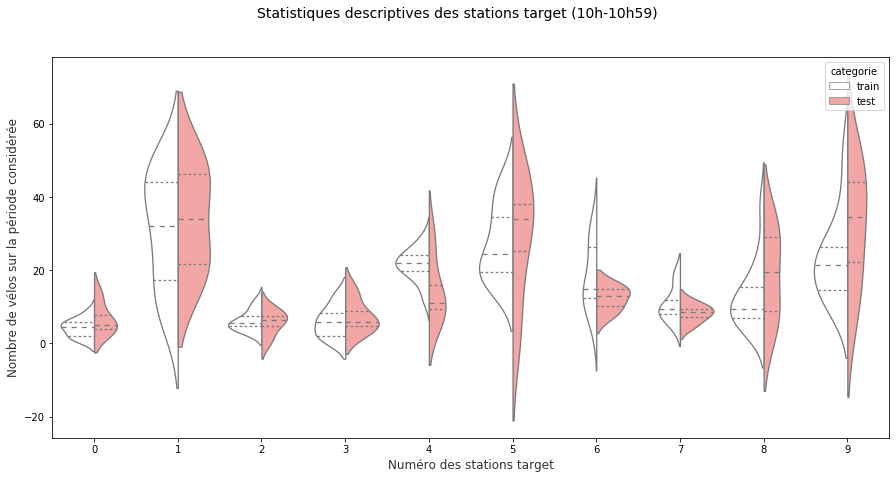

In [152]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives des stations target (10h-10h59)', fontsize=14)

sns.violinplot(x = 'num_station_target', y = 'nb_velibs',data=tous_les_dfs_10h, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Numéro des stations target",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


In [153]:
ptbl_10h_sum = PrettyTable()
ptbl_10h_sum.field_names = ["Mean(Occupation) 10h-10h59", "Mean(Std(Occupation)) 10h-10h59", "Mean MAE LR 10h-10h59", "Mean MAE RF 10h-10h59", "Mean MAE méthode naïve 10h-10h59"]
mean_capacity_10h = 0
mean_std_occupation_10h = 0
mean_MAE_lr_10h = 0
mean_MAE_rf_10h = 0
mean_MAE_naif_10h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_10h.items():
    mean_capacity_10h += resultats_10h[key][9]
    mean_std_occupation_10h += resultats_10h[key][15]
    mean_MAE_lr_10h += resultats_10h[key][4]
    mean_MAE_rf_10h += resultats_10h[key][6]
    mean_MAE_naif_10h += resultats_10h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_10h = round(mean_capacity_10h/len(resultats_10h),2)
mean_std_occupation_10h = round(mean_std_occupation_10h/len(resultats_10h),2)
mean_MAE_lr_10h = round(mean_MAE_lr_10h/len(resultats_10h),2)
mean_MAE_rf_10h = round(mean_MAE_rf_10h/len(resultats_10h),2)
mean_MAE_naif_10h = round(mean_MAE_naif_10h/len(resultats_10h),2)

# Visualisation des performances avec Prettytable
ptbl_10h_sum.add_row([mean_capacity_10h, mean_std_occupation_10h, mean_MAE_lr_10h, mean_MAE_rf_10h, mean_MAE_naif_10h])
print(ptbl_10h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 10h-10h59 | Mean(Std(Occupation)) 10h-10h59 | Mean MAE LR 10h-10h59 | Mean MAE RF 10h-10h59 | Mean MAE méthode naïve 10h-10h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           16.78            |               8.46              |          3.4          |          4.24         |               5.88               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 11h-11h59

In [154]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_11h = {}
# Préparation de la visualisation des résultats :
ptbl_11h = PrettyTable()
ptbl_11h.field_names = ["Station target", "Mean(Occupation) 11h-11h59", "Std(Occupation) 11h-11h59", "MAE LR 11h-11h59", "MAE RF 11h-11h59", "MAE méthode intuitive 11h-11h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 11h
    df_1h = sous_df_1h(df_h,11)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_11h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_11h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_11h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 11h-11h59 | Std(Occupation) 11h-11h59 | MAE LR 11h-11h59 | MAE RF 11h-11h59 | MAE méthode intuitive 11h-11h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            7.0             |            5.15           |       0.39       |       1.56       |               4.4               |
|   station_1    |            34.6            |           14.01           |       4.87       |       9.98       |               13.4              |
|   station_2    |            5.2             |            2.49           |       0.41       |       2.12       |               2.0               |
|   station_3    |            7.4             |            5.08           |       0.54       |       1.28       

In [155]:
ptbl_11h_sum = PrettyTable()
ptbl_11h_sum.field_names = ["Mean(Occupation) 11h-11h59", "Mean(Std(Occupation)) 11h-11h59", "Mean MAE LR 11h-11h59", "Mean MAE RF 11h-11h59", "Mean MAE méthode naïve 11h-11h59"]
mean_capacity_11h = 0
mean_std_occupation_11h = 0
mean_MAE_lr_11h = 0
mean_MAE_rf_11h = 0
mean_MAE_naif_11h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_11h.items():
    mean_capacity_11h += resultats_11h[key][9]
    mean_std_occupation_11h += resultats_11h[key][15]
    mean_MAE_lr_11h += resultats_11h[key][4]
    mean_MAE_rf_11h += resultats_11h[key][6]
    mean_MAE_naif_11h += resultats_11h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_11h = round(mean_capacity_11h/len(resultats_11h),2)
mean_std_occupation_11h = round(mean_std_occupation_11h/len(resultats_11h),2)
mean_MAE_lr_11h = round(mean_MAE_lr_11h/len(resultats_11h),2)
mean_MAE_rf_11h = round(mean_MAE_rf_11h/len(resultats_11h),2)
mean_MAE_naif_11h = round(mean_MAE_naif_11h/len(resultats_11h),2)

# Visualisation des performances avec Prettytable
ptbl_11h_sum.add_row([mean_capacity_11h, mean_std_occupation_11h, mean_MAE_lr_11h, mean_MAE_rf_11h, mean_MAE_naif_11h])
print(ptbl_11h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 11h-11h59 | Mean(Std(Occupation)) 11h-11h59 | Mean MAE LR 11h-11h59 | Mean MAE RF 11h-11h59 | Mean MAE méthode naïve 11h-11h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.58            |               8.38              |          2.68         |          4.26         |               6.02               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 12h-12h59

In [156]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_12h = {}
# Préparation de la visualisation des résultats :
ptbl_12h = PrettyTable()
ptbl_12h.field_names = ["Station target", "Mean(Occupation) 12h-12h59", "Std(Occupation) 12h-12h59", "MAE LR 12h-12h59", "MAE RF 12h-12h59", "MAE méthode intuitive 12h-12h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 12h
    df_1h = sous_df_1h(df_h,12)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_12h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_12h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_12h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 12h-12h59 | Std(Occupation) 12h-12h59 | MAE LR 12h-12h59 | MAE RF 12h-12h59 | MAE méthode intuitive 12h-12h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            6.67            |            4.76           |       0.4        |       0.83       |               3.33              |
|   station_1    |           36.83            |           15.39           |       4.19       |       8.97       |              12.67              |
|   station_2    |            4.67            |            3.2            |       2.11       |       1.4        |               2.33              |
|   station_3    |            7.17            |            3.19           |       1.74       |       1.22       

In [157]:
ptbl_12h_sum = PrettyTable()
ptbl_12h_sum.field_names = ["Mean(Occupation) 12h-12h59", "Mean(Std(Occupation)) 12h-12h59", "Moyenne MAE LR 12h-12h59", "Moyenne MAE RF 12h-12h59", "Moyenne MAE méthode naïve 12h-12h59"]
mean_capacity_12h = 0
mean_std_occupation_12h = 0
mean_MAE_lr_12h = 0
mean_MAE_rf_12h = 0
mean_MAE_naif_12h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_12h.items():
    mean_capacity_12h += resultats_12h[key][9]
    mean_std_occupation_12h += resultats_12h[key][15]
    mean_MAE_lr_12h += resultats_12h[key][4]
    mean_MAE_rf_12h += resultats_12h[key][6]
    mean_MAE_naif_12h += resultats_12h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_12h = round(mean_capacity_12h/len(resultats_12h),2)
mean_std_occupation_12h = round(mean_std_occupation_12h/len(resultats_12h),2)
mean_MAE_lr_12h = round(mean_MAE_lr_12h/len(resultats_12h),2)
mean_MAE_rf_12h = round(mean_MAE_rf_12h/len(resultats_12h),2)
mean_MAE_naif_12h = round(mean_MAE_naif_12h/len(resultats_12h),2)

# Visualisation des performances avec Prettytable
ptbl_12h_sum.add_row([mean_capacity_12h, mean_std_occupation_12h, mean_MAE_lr_12h, mean_MAE_rf_12h, mean_MAE_naif_12h])
print(ptbl_12h_sum)

+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+
| Mean(Occupation) 12h-12h59 | Mean(Std(Occupation)) 12h-12h59 | Moyenne MAE LR 12h-12h59 | Moyenne MAE RF 12h-12h59 | Moyenne MAE méthode naïve 12h-12h59 |
+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+
|           16.73            |               7.74              |           2.33           |           4.01           |                 5.2                 |
+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+


# Résultats à 13h-13h59

In [158]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_13h = {}
# Préparation de la visualisation des résultats :
ptbl_13h = PrettyTable()
ptbl_13h.field_names = ["Station target", "Mean(Occupation) 13h-13h59", "Std(Occupation) 13h-13h59", "MAE LR 13h-13h59", "MAE RF 13h-13h59", "MAE méthode intuitive 13h-13h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 13h
    df_1h = sous_df_1h(df_h,13)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_13h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_13h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_13h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 13h-13h59 | Std(Occupation) 13h-13h59 | MAE LR 13h-13h59 | MAE RF 13h-13h59 | MAE méthode intuitive 13h-13h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            3.8             |            1.92           |       0.93       |       0.66       |               2.2               |
|   station_1    |            38.4            |           11.39           |       2.99       |       8.2        |               9.8               |
|   station_2    |            5.8             |            2.49           |       1.62       |       1.78       |               2.4               |
|   station_3    |            3.8             |            2.17           |       1.11       |       1.26       

In [159]:
ptbl_13h_sum = PrettyTable()
ptbl_13h_sum.field_names = ["Mean(Occupation) 13h-13h59", "Mean(Std(Occupation)) 13h-13h59", "Mean MAE LR 13h-13h59", "Mean MAE RF 13h-13h59", "Mean MAE méthode naïve 13h-13h59"]
mean_capacity_13h = 0
mean_std_occupation_13h = 0
mean_MAE_lr_13h = 0
mean_MAE_rf_13h = 0
mean_MAE_naif_13h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_13h.items():
    mean_capacity_13h += resultats_13h[key][9]
    mean_std_occupation_13h += resultats_13h[key][15]
    mean_MAE_lr_13h += resultats_13h[key][4]
    mean_MAE_rf_13h += resultats_13h[key][6]
    mean_MAE_naif_13h += resultats_13h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_13h = round(mean_capacity_13h/len(resultats_13h),2)
mean_std_occupation_13h = round(mean_std_occupation_13h/len(resultats_13h),2)
mean_MAE_lr_13h = round(mean_MAE_lr_13h/len(resultats_13h),2)
mean_MAE_rf_13h = round(mean_MAE_rf_13h/len(resultats_13h),2)
mean_MAE_naif_13h = round(mean_MAE_naif_13h/len(resultats_13h),2)

# Visualisation des performances avec Prettytable
ptbl_13h_sum.add_row([mean_capacity_13h, mean_std_occupation_13h, mean_MAE_lr_13h, mean_MAE_rf_13h, mean_MAE_naif_13h])
print(ptbl_13h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 13h-13h59 | Mean(Std(Occupation)) 13h-13h59 | Mean MAE LR 13h-13h59 | Mean MAE RF 13h-13h59 | Mean MAE méthode naïve 13h-13h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           16.32            |               6.26              |          2.49         |          4.22         |               6.56               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 14h-14h59

In [160]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_14h = {}
# Préparation de la visualisation des résultats :
ptbl_14h = PrettyTable()
ptbl_14h.field_names = ["Station target", "Mean(Occupation) 14h-14h59", "Std(Occupation) 14h-14h59", "MAE LR 14h-14h59", "MAE RF 14h-14h59", "MAE méthode intuitive 14h-14h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 14h
    df_1h = sous_df_1h(df_h,14)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_14h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_14h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_14h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 14h-14h59 | Std(Occupation) 14h-14h59 | MAE LR 14h-14h59 | MAE RF 14h-14h59 | MAE méthode intuitive 14h-14h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            3.67            |            1.86           |       0.84       |       1.55       |               2.67              |
|   station_1    |           38.17            |           14.22           |       5.27       |       7.53       |              12.17              |
|   station_2    |            5.83            |            3.87           |       1.84       |       1.92       |               3.17              |
|   station_3    |            4.33            |            3.93           |       1.4        |       1.0        

In [161]:
ptbl_14h_sum = PrettyTable()
ptbl_14h_sum.field_names = ["Mean(Occupation) 14h-14h59", "Mean(Std(Occupation)) 14h-14h59", "Mean MAE LR 14h-14h59", "Mean MAE RF 14h-14h59", "Mean MAE méthode naïve 14h-14h59"]
mean_capacity_14h = 0
mean_std_occupation_14h = 0
mean_MAE_lr_14h = 0
mean_MAE_rf_14h = 0
mean_MAE_naif_14h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_14h.items():
    mean_capacity_14h += resultats_14h[key][9]
    mean_std_occupation_14h += resultats_14h[key][15]
    mean_MAE_lr_14h += resultats_14h[key][4]
    mean_MAE_rf_14h += resultats_14h[key][6]
    mean_MAE_naif_14h += resultats_14h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_14h = round(mean_capacity_14h/len(resultats_14h),2)
mean_std_occupation_14h = round(mean_std_occupation_14h/len(resultats_14h),2)
mean_MAE_lr_14h = round(mean_MAE_lr_14h/len(resultats_14h),2)
mean_MAE_rf_14h = round(mean_MAE_rf_14h/len(resultats_14h),2)
mean_MAE_naif_14h = round(mean_MAE_naif_14h/len(resultats_14h),2)

# Visualisation des performances avec Prettytable
ptbl_14h_sum.add_row([mean_capacity_14h, mean_std_occupation_14h, mean_MAE_lr_14h, mean_MAE_rf_14h, mean_MAE_naif_14h])
print(ptbl_14h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 14h-14h59 | Mean(Std(Occupation)) 14h-14h59 | Mean MAE LR 14h-14h59 | Mean MAE RF 14h-14h59 | Mean MAE méthode naïve 14h-14h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           16.07            |               7.07              |          3.43         |          4.78         |               6.03               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 15h-15h59

In [162]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_15h = {}
# Préparation de la visualisation des résultats :
ptbl_15h = PrettyTable()
ptbl_15h.field_names = ["Station target", "Mean(Occupation) 15h-15h59", "Std(Occupation) 15h-15h59", "MAE LR 15h-15h59", "MAE RF 15h-15h59", "MAE méthode intuitive 15h-15h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 15h
    df_1h = sous_df_1h(df_h,15)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_15h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_15h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_15h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 15h-15h59 | Std(Occupation) 15h-15h59 | MAE LR 15h-15h59 | MAE RF 15h-15h59 | MAE méthode intuitive 15h-15h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            3.17            |            2.4            |       1.05       |       0.82       |               1.33              |
|   station_1    |            40.0            |           14.52           |       5.65       |       7.57       |               12.5              |
|   station_2    |            5.5             |            2.74           |       2.1        |       1.27       |               3.17              |
|   station_3    |            4.0             |            1.67           |       1.63       |       1.65       

In [163]:
ptbl_15h_sum = PrettyTable()
ptbl_15h_sum.field_names = ["Mean(Occupation) 15h-15h59", "Mean(Std(Occupation)) 15h-15h59", "Mean MAE LR 15h-15h59", "Mean MAE RF 15h-15h59", "Mean MAE méthode naïve 15h-15h59"]
mean_capacity_15h = 0
mean_std_occupation_15h = 0
mean_MAE_lr_15h = 0
mean_MAE_rf_15h = 0
mean_MAE_naif_15h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_15h.items():
    mean_capacity_15h += resultats_15h[key][9]
    mean_std_occupation_15h += resultats_15h[key][15]
    mean_MAE_lr_15h += resultats_15h[key][4]
    mean_MAE_rf_15h += resultats_15h[key][6]
    mean_MAE_naif_15h += resultats_15h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_15h = round(mean_capacity_15h/len(resultats_15h),2)
mean_std_occupation_15h = round(mean_std_occupation_15h/len(resultats_15h),2)
mean_MAE_lr_15h = round(mean_MAE_lr_15h/len(resultats_15h),2)
mean_MAE_rf_15h = round(mean_MAE_rf_15h/len(resultats_15h),2)
mean_MAE_naif_15h = round(mean_MAE_naif_15h/len(resultats_15h),2)

# Visualisation des performances avec Prettytable
ptbl_15h_sum.add_row([mean_capacity_15h, mean_std_occupation_15h, mean_MAE_lr_15h, mean_MAE_rf_15h, mean_MAE_naif_15h])
print(ptbl_15h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 15h-15h59 | Mean(Std(Occupation)) 15h-15h59 | Mean MAE LR 15h-15h59 | Mean MAE RF 15h-15h59 | Mean MAE méthode naïve 15h-15h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           15.97            |               7.43              |          3.5          |          3.93         |               5.15               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 16h-16h59

In [164]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_16h = {}
# Préparation de la visualisation des résultats :
ptbl_16h = PrettyTable()
ptbl_16h.field_names = ["Station target", "Mean(Occupation) 16h-16h59", "Std(Occupation) 16h-16h59", "MAE LR 16h-16h59", "MAE RF 16h-16h59", "MAE méthode intuitive 16h-16h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 16h
    df_1h = sous_df_1h(df_h,16)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_16h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_16h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_16h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 16h-16h59 | Std(Occupation) 16h-16h59 | MAE LR 16h-16h59 | MAE RF 16h-16h59 | MAE méthode intuitive 16h-16h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            2.67            |            1.51           |       1.25       |       0.5        |               1.67              |
|   station_1    |           44.17            |           10.83           |       5.58       |       8.7        |              10.83              |
|   station_2    |            2.83            |            2.86           |       1.15       |       1.63       |               2.17              |
|   station_3    |            3.17            |            1.83           |       1.16       |       1.92       

In [165]:
ptbl_16h_sum = PrettyTable()
ptbl_16h_sum.field_names = ["Mean(Occupation) 16h-16h59", "Mean(Std(Occupation)) 16h-16h59", "Mean MAE LR 16h-16h59", "Mean MAE RF 16h-16h59", "Mean MAE méthode naïve 16h-16h59"]
mean_capacity_16h = 0
mean_std_occupation_16h = 0
mean_MAE_lr_16h = 0
mean_MAE_rf_16h = 0
mean_MAE_naif_16h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_16h.items():
    mean_capacity_16h += resultats_16h[key][9]
    mean_std_occupation_16h += resultats_16h[key][15]
    mean_MAE_lr_16h += resultats_16h[key][4]
    mean_MAE_rf_16h += resultats_16h[key][6]
    mean_MAE_naif_16h += resultats_16h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_16h = round(mean_capacity_16h/len(resultats_16h),2)
mean_std_occupation_16h = round(mean_std_occupation_16h/len(resultats_16h),2)
mean_MAE_lr_16h = round(mean_MAE_lr_16h/len(resultats_16h),2)
mean_MAE_rf_16h = round(mean_MAE_rf_16h/len(resultats_16h),2)
mean_MAE_naif_16h = round(mean_MAE_naif_16h/len(resultats_16h),2)

# Visualisation des performances avec Prettytable
ptbl_16h_sum.add_row([mean_capacity_16h, mean_std_occupation_16h, mean_MAE_lr_16h, mean_MAE_rf_16h, mean_MAE_naif_16h])
print(ptbl_16h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 16h-16h59 | Mean(Std(Occupation)) 16h-16h59 | Mean MAE LR 16h-16h59 | Mean MAE RF 16h-16h59 | Mean MAE méthode naïve 16h-16h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           15.63            |               7.07              |          3.16         |          3.97         |               4.9                |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 17h-17h59

In [166]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_17h = {}
# Préparation de la visualisation des résultats :
ptbl_17h = PrettyTable()
ptbl_17h.field_names = ["Station target", "Mean(Occupation) 17h-17h59", "Std(Occupation) 17h-17h59", "MAE LR 17h-17h59", "MAE RF 17h-17h59", "MAE méthode intuitive 17h-17h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 17h
    df_1h = sous_df_1h(df_h,17)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_17h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_17h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_17h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 17h-17h59 | Std(Occupation) 17h-17h59 | MAE LR 17h-17h59 | MAE RF 17h-17h59 | MAE méthode intuitive 17h-17h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            3.2             |            2.95           |       1.49       |       2.54       |               5.2               |
|   station_1    |            46.4            |           11.06           |       7.14       |       8.18       |               11.8              |
|   station_2    |            4.0             |            3.74           |       2.12       |       1.64       |               2.6               |
|   station_3    |            3.0             |            1.22           |       0.39       |       1.6        

In [167]:
ptbl_17h_sum = PrettyTable()
ptbl_17h_sum.field_names = ["Mean(Occupation) 17h-17h59", "Mean(Std(Occupation)) 17h-17h59", "Moyenne MAE LR 17h-17h59", "Moyenne MAE RF 17h-17h59", "Moyenne MAE méthode naïve 17h-17h59"]
mean_capacity_17h = 0
mean_std_occupation_17h = 0
mean_MAE_lr_17h = 0
mean_MAE_rf_17h = 0
mean_MAE_naif_17h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_17h.items():
    mean_capacity_17h += resultats_17h[key][9]
    mean_std_occupation_17h += resultats_17h[key][15]
    mean_MAE_lr_17h += resultats_17h[key][4]
    mean_MAE_rf_17h += resultats_17h[key][6]
    mean_MAE_naif_17h += resultats_17h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_17h = round(mean_capacity_17h/len(resultats_17h),2)
mean_std_occupation_17h = round(mean_std_occupation_17h/len(resultats_17h),2)
mean_MAE_lr_17h = round(mean_MAE_lr_17h/len(resultats_17h),2)
mean_MAE_rf_17h = round(mean_MAE_rf_17h/len(resultats_17h),2)
mean_MAE_naif_17h = round(mean_MAE_naif_17h/len(resultats_17h),2)

# Visualisation des performances avec Prettytable
ptbl_17h_sum.add_row([mean_capacity_17h, mean_std_occupation_17h, mean_MAE_lr_17h, mean_MAE_rf_17h, mean_MAE_naif_17h])
print(ptbl_17h_sum)

+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+
| Mean(Occupation) 17h-17h59 | Mean(Std(Occupation)) 17h-17h59 | Moyenne MAE LR 17h-17h59 | Moyenne MAE RF 17h-17h59 | Moyenne MAE méthode naïve 17h-17h59 |
+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+
|           17.52            |               7.0               |           4.07           |           4.85           |                 5.74                |
+----------------------------+---------------------------------+--------------------------+--------------------------+-------------------------------------+


# Résultats à 18h-18h59

In [168]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_18h = {}
# Préparation de la visualisation des résultats :
ptbl_18h = PrettyTable()
ptbl_18h.field_names = ["Station target", "Mean(Occupation) 18h-18h59", "Std(Occupation) 18h-18h59", "MAE LR 18h-18h59", "MAE RF 18h-18h59", "MAE méthode intuitive 18h-18h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 18h
    df_1h = sous_df_1h(df_h,18)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_18h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_18h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_18h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 18h-18h59 | Std(Occupation) 18h-18h59 | MAE LR 18h-18h59 | MAE RF 18h-18h59 | MAE méthode intuitive 18h-18h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            4.5             |            2.88           |       1.05       |       1.13       |               3.83              |
|   station_1    |           44.17            |            10.8           |       4.5        |       6.9        |              10.67              |
|   station_2    |            4.33            |            3.27           |       0.97       |       1.73       |               2.83              |
|   station_3    |            4.67            |            3.39           |       1.58       |       1.38       

In [169]:
ptbl_18h_sum = PrettyTable()
ptbl_18h_sum.field_names = ["Mean(Occupation) 18h-18h59", "Mean(Std(Occupation)) 18h-18h59", "Mean MAE LR 18h-18h59", "Moyenne MAE RF 18h-18h59", "Moyenne MAE méthode naïve 18h-18h59"]
mean_capacity_18h = 0
mean_std_occupation_18h = 0
mean_MAE_lr_18h = 0
mean_MAE_rf_18h = 0
mean_MAE_naif_18h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_18h.items():
    mean_capacity_18h += resultats_18h[key][9]
    mean_std_occupation_18h += resultats_18h[key][15]
    mean_MAE_lr_18h += resultats_18h[key][4]
    mean_MAE_rf_18h += resultats_18h[key][6]
    mean_MAE_naif_18h += resultats_18h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_18h = round(mean_capacity_18h/len(resultats_18h),2)
mean_std_occupation_18h = round(mean_std_occupation_18h/len(resultats_18h),2)
mean_MAE_lr_18h = round(mean_MAE_lr_18h/len(resultats_18h),2)
mean_MAE_rf_18h = round(mean_MAE_rf_18h/len(resultats_18h),2)
mean_MAE_naif_18h = round(mean_MAE_naif_18h/len(resultats_18h),2)

# Visualisation des performances avec Prettytable
ptbl_18h_sum.add_row([mean_capacity_18h, mean_std_occupation_18h, mean_MAE_lr_18h, mean_MAE_rf_18h, mean_MAE_naif_18h])
print(ptbl_18h_sum)

+----------------------------+---------------------------------+-----------------------+--------------------------+-------------------------------------+
| Mean(Occupation) 18h-18h59 | Mean(Std(Occupation)) 18h-18h59 | Mean MAE LR 18h-18h59 | Moyenne MAE RF 18h-18h59 | Moyenne MAE méthode naïve 18h-18h59 |
+----------------------------+---------------------------------+-----------------------+--------------------------+-------------------------------------+
|           17.42            |               6.79              |          3.05         |           4.39           |                 5.27                |
+----------------------------+---------------------------------+-----------------------+--------------------------+-------------------------------------+


# Résultats à 19h-19h59

In [170]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_19h = {}
# Préparation de la visualisation des résultats :
ptbl_19h = PrettyTable()
ptbl_19h.field_names = ["Station target", "Mean(Occupation) 19h-19h59", "Std(Occupation) 19h-19h59", "MAE LR 19h-19h59", "MAE RF 19h-19h59", "MAE méthode intuitive 19h-19h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 19h
    df_1h = sous_df_1h(df_h,19)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_19h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_19h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_19h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 19h-19h59 | Std(Occupation) 19h-19h59 | MAE LR 19h-19h59 | MAE RF 19h-19h59 | MAE méthode intuitive 19h-19h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            4.4             |            3.13           |       0.9        |       1.26       |               4.2               |
|   station_1    |            43.0            |           10.07           |       6.94       |       8.18       |               10.8              |
|   station_2    |            4.8             |            3.27           |       1.84       |       2.38       |               2.8               |
|   station_3    |            5.4             |            3.05           |       1.22       |       1.66       

In [171]:
ptbl_19h_sum = PrettyTable()
ptbl_19h_sum.field_names = ["Mean(Occupation) 19h-19h59", "Mean(Std(Occupation)) 19h-19h59", "Mean MAE LR 19h-19h59", "Mean MAE RF 19h-19h59", "Mean MAE méthode naïve 19h-19h59"]
mean_capacity_19h = 0
mean_std_occupation_19h = 0
mean_MAE_lr_19h = 0
mean_MAE_rf_19h = 0
mean_MAE_naif_19h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_19h.items():
    mean_capacity_19h += resultats_19h[key][9]
    mean_std_occupation_19h += resultats_19h[key][15]
    mean_MAE_lr_19h += resultats_19h[key][4]
    mean_MAE_rf_19h += resultats_19h[key][6]
    mean_MAE_naif_19h += resultats_19h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_19h = round(mean_capacity_19h/len(resultats_19h),2)
mean_std_occupation_19h = round(mean_std_occupation_19h/len(resultats_19h),2)
mean_MAE_lr_19h = round(mean_MAE_lr_19h/len(resultats_19h),2)
mean_MAE_rf_19h = round(mean_MAE_rf_19h/len(resultats_19h),2)
mean_MAE_naif_19h = round(mean_MAE_naif_19h/len(resultats_19h),2)

# Visualisation des performances avec Prettytable
ptbl_19h_sum.add_row([mean_capacity_19h, mean_std_occupation_19h, mean_MAE_lr_19h, mean_MAE_rf_19h, mean_MAE_naif_19h])
print(ptbl_19h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 19h-19h59 | Mean(Std(Occupation)) 19h-19h59 | Mean MAE LR 19h-19h59 | Mean MAE RF 19h-19h59 | Mean MAE méthode naïve 19h-19h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.44            |               7.17              |          3.43         |          4.35         |               5.1                |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 20h-20h59

In [172]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_20h = {}
# Préparation de la visualisation des résultats :
ptbl_20h = PrettyTable()
ptbl_20h.field_names = ["Station target", "Mean(Occupation) 20h-20h59", "Std(Occupation) 20h-20h59", "MAE LR 20h-20h59", "MAE RF 20h-20h59", "MAE méthode intuitive 20h-20h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 20h
    df_1h = sous_df_1h(df_h,20)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_20h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_20h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_20h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 20h-20h59 | Std(Occupation) 20h-20h59 | MAE LR 20h-20h59 | MAE RF 20h-20h59 | MAE méthode intuitive 20h-20h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            5.0             |            3.29           |       0.98       |       1.15       |               3.5               |
|   station_1    |            43.0            |           10.64           |       5.35       |       9.65       |               9.83              |
|   station_2    |            3.83            |            1.94           |       1.66       |       2.05       |               3.0               |
|   station_3    |            5.5             |            2.35           |       1.76       |       1.67       

In [173]:
ptbl_20h_sum = PrettyTable()
ptbl_20h_sum.field_names = ["Mean(Occupation) 20h-20h59", "Mean(Std(Occupation)) 20h-20h59", "Mean MAE LR 20h-20h59", "Mean MAE RF 20h-20h59", "Mean MAE méthode naïve 20h-20h59"]
mean_capacity_20h = 0
mean_std_occupation_20h = 0
mean_MAE_lr_20h = 0
mean_MAE_rf_20h = 0
mean_MAE_naif_20h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_20h.items():
    mean_capacity_20h += resultats_20h[key][9]
    mean_std_occupation_20h += resultats_20h[key][15]
    mean_MAE_lr_20h += resultats_20h[key][4]
    mean_MAE_rf_20h += resultats_20h[key][6]
    mean_MAE_naif_20h += resultats_20h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_20h = round(mean_capacity_20h/len(resultats_20h),2)
mean_std_occupation_20h = round(mean_std_occupation_20h/len(resultats_20h),2)
mean_MAE_lr_20h = round(mean_MAE_lr_20h/len(resultats_20h),2)
mean_MAE_rf_20h = round(mean_MAE_rf_20h/len(resultats_20h),2)
mean_MAE_naif_20h = round(mean_MAE_naif_20h/len(resultats_20h),2)

# Visualisation des performances avec Prettytable
ptbl_20h_sum.add_row([mean_capacity_20h, mean_std_occupation_20h, mean_MAE_lr_20h, mean_MAE_rf_20h, mean_MAE_naif_20h])
print(ptbl_20h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 20h-20h59 | Mean(Std(Occupation)) 20h-20h59 | Mean MAE LR 20h-20h59 | Mean MAE RF 20h-20h59 | Mean MAE méthode naïve 20h-20h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.63            |               7.12              |          3.05         |          4.32         |               4.82               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 21h-21h59

In [174]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_21h = {}
# Préparation de la visualisation des résultats :
ptbl_21h = PrettyTable()
ptbl_21h.field_names = ["Station target", "Mean(Occupation) 21h-21h59", "Std(Occupation) 21h-21h59", "MAE LR 21h-21h59", "MAE RF 21h-21h59", "MAE méthode intuitive 21h-21h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 21h
    df_1h = sous_df_1h(df_h,21)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_21h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_21h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_21h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 21h-21h59 | Std(Occupation) 21h-21h59 | MAE LR 21h-21h59 | MAE RF 21h-21h59 | MAE méthode intuitive 21h-21h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            5.17            |            2.99           |       0.98       |       1.25       |               3.0               |
|   station_1    |           42.67            |           10.46           |       7.73       |       9.52       |               11.5              |
|   station_2    |            5.0             |            1.9            |       1.93       |       2.65       |               3.33              |
|   station_3    |            5.33            |            2.73           |       1.35       |       1.7        

In [175]:
ptbl_21h_sum = PrettyTable()
ptbl_21h_sum.field_names = ["Mean(Occupation) 21h-21h59", "Mean(Std(Occupation)) 21h-21h59", "Mean MAE LR 21h-21h59", "Mean MAE RF 21h-21h59", "Mean MAE méthode naïve 21h-21h59"]
mean_capacity_21h = 0
mean_std_occupation_21h = 0
mean_MAE_lr_21h = 0
mean_MAE_rf_21h = 0
mean_MAE_naif_21h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_21h.items():
    mean_capacity_21h += resultats_21h[key][9]
    mean_std_occupation_21h += resultats_21h[key][15]
    mean_MAE_lr_21h += resultats_21h[key][4]
    mean_MAE_rf_21h += resultats_21h[key][6]
    mean_MAE_naif_21h += resultats_21h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_21h = round(mean_capacity_21h/len(resultats_18h),2)
mean_std_occupation_21h = round(mean_std_occupation_21h/len(resultats_18h),2)
mean_MAE_lr_21h = round(mean_MAE_lr_21h/len(resultats_18h),2)
mean_MAE_rf_21h = round(mean_MAE_rf_21h/len(resultats_18h),2)
mean_MAE_naif_21h = round(mean_MAE_naif_21h/len(resultats_18h),2)

# Visualisation des performances avec Prettytable
ptbl_21h_sum.add_row([mean_capacity_21h, mean_std_occupation_21h, mean_MAE_lr_21h, mean_MAE_rf_21h, mean_MAE_naif_21h])
print(ptbl_21h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 21h-21h59 | Mean(Std(Occupation)) 21h-21h59 | Mean MAE LR 21h-21h59 | Mean MAE RF 21h-21h59 | Mean MAE méthode naïve 21h-21h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           18.05            |               6.68              |          3.04         |          4.74         |               5.17               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 22h-22h59

In [176]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_22h = {}
# Préparation de la visualisation des résultats :
ptbl_22h = PrettyTable()
ptbl_22h.field_names = ["Station target", "Mean(Occupation) 22h-22h59", "Std(Occupation) 22h-22h59", "MAE LR 22h-22h59", "MAE RF 22h-22h59", "MAE méthode intuitive 22h-22h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 22h
    df_1h = sous_df_1h(df_h,22)
    df_ml = sous_df_ml(df_1h, num_station)

    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_22h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_22h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_22h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 22h-22h59 | Std(Occupation) 22h-22h59 | MAE LR 22h-22h59 | MAE RF 22h-22h59 | MAE méthode intuitive 22h-22h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            4.83            |            2.99           |       0.98       |       1.17       |               3.33              |
|   station_1    |            42.5            |           10.09           |       5.41       |       9.32       |              12.17              |
|   station_2    |            5.33            |            1.37           |       1.71       |       1.65       |               3.0               |
|   station_3    |            4.17            |            3.06           |       2.6        |       2.0        

In [177]:
ptbl_22h_sum = PrettyTable()
ptbl_22h_sum.field_names = ["Mean(Occupation) 22h-22h59", "Mean(Std(Occupation)) 22h-22h59", "Mean MAE LR 22h-22h59", "Mean MAE RF 22h-22h59", "Mean MAE méthode naïve 22h-22h59"]
mean_capacity_22h = 0
mean_std_occupation_22h = 0
mean_MAE_lr_22h = 0
mean_MAE_rf_22h = 0
mean_MAE_naif_22h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_22h.items():
    mean_capacity_22h += resultats_22h[key][9]
    mean_std_occupation_22h += resultats_22h[key][15]
    mean_MAE_lr_22h += resultats_22h[key][4]
    mean_MAE_rf_22h += resultats_22h[key][6]
    mean_MAE_naif_22h += resultats_22h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_22h = round(mean_capacity_22h/len(resultats_18h),2)
mean_std_occupation_22h = round(mean_std_occupation_22h/len(resultats_18h),2)
mean_MAE_lr_22h = round(mean_MAE_lr_22h/len(resultats_18h),2)
mean_MAE_rf_22h = round(mean_MAE_rf_22h/len(resultats_18h),2)
mean_MAE_naif_22h = round(mean_MAE_naif_22h/len(resultats_18h),2)

# Visualisation des performances avec Prettytable
ptbl_22h_sum.add_row([mean_capacity_22h, mean_std_occupation_22h, mean_MAE_lr_22h, mean_MAE_rf_22h, mean_MAE_naif_22h])
print(ptbl_22h_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 22h-22h59 | Mean(Std(Occupation)) 22h-22h59 | Mean MAE LR 22h-22h59 | Mean MAE RF 22h-22h59 | Mean MAE méthode naïve 22h-22h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.53            |               6.51              |          3.16         |          4.56         |               5.22               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


# Résultats à 23h-23h59

In [178]:
# Pour chaque station, on garde le numéro de la station dans le dataframe df_velib, les modèle lr et rf
resultats_23h = {}
# Préparation de la visualisation des résultats :
ptbl_23h = PrettyTable()
ptbl_23h.field_names = ["Station target", "Mean(Occupation) 23h-23h59", "Std(Occupation) 23h-23h59", "MAE LR 23h-23h59", "MAE RF 23h-23h59", "MAE méthode intuitive 23h-23h59"]

# Dataframe pour la Régression Linéaire et le Random Forest
for num_station in range(len(stations_tests)):
    
    # Préparation du sous_df pour le ML pour 23h
    df_1h = sous_df_1h(df_h,23)
    df_ml = sous_df_ml(df_1h, num_station)


    # Choix des features i.e. des 30 stations les plus corréelées à la station target
    features = choix_stations_correlees(df_ml,30,num_station)

    # Machine Learning
    X = df_ml[features]
    # Préparation de la target
    y = df_ml['y']
    # Séparation en données de test et d'entrainement
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
    
    # 1- Régression linéaire
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_prediction_lr = lr.predict(X_test)
    MAE_lr = round(mean_absolute_error(y_test, y_prediction_lr),2)

    # 2- Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_prediction_rf = rf.predict(X_test)
    MAE_rf = round(mean_absolute_error(y_test, y_prediction_rf),2)

    # 3- Méthode naïve ou bien "intuitive" c'est-à-dire prédire que ce qui se passe 1 jour plus tard est exactement la même chose que la            veille
    df_naif = X_test.copy()
    #MAE_naif = round(abs(X_test[i]-y_test).mean() , 2)
    MAE_naif = round(mean_absolute_error(X_test[num_station], y_test),2)

    # Capacité moyenne de la station sur la période observée
    occupation_moyenne = round(X_test[num_station].mean(),2)
    # Variance de la capacité sur la période observée
    variance_occupation = round(X_test[num_station].std(),2)

    # Mise en forme des résultats
    y_test = pd.DataFrame(y_test)
    index = y_test.index
    # Renommer pour plus de clarté
    y_prediction_lr = pd.DataFrame(y_prediction_lr, index = index)
    y_prediction_rf = pd.DataFrame(y_prediction_rf, index = index)
    y_naif = pd.DataFrame(X_test[num_station])
    y_prediction_naif = y_test

    # Stockage des résultats : numéro de la station, les modèles, et les MAE de chaque modèle
    resultats_23h[stations_tests[num_station]] = [i, X, y, lr, MAE_lr, rf, MAE_rf, df_naif, MAE_naif, occupation_moyenne, y_test, y_prediction_lr, y_prediction_rf, y_naif, y_prediction_naif, variance_occupation]

    # Visualisation des performances avec Prettytable
    ptbl_23h.add_row([stations_tests[num_station], occupation_moyenne, variance_occupation, MAE_lr, MAE_rf, MAE_naif])
    
print(ptbl_23h)

+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
| Station target | Mean(Occupation) 23h-23h59 | Std(Occupation) 23h-23h59 | MAE LR 23h-23h59 | MAE RF 23h-23h59 | MAE méthode intuitive 23h-23h59 |
+----------------+----------------------------+---------------------------+------------------+------------------+---------------------------------+
|   station_0    |            4.83            |            2.99           |       1.33       |       1.3        |               3.33              |
|   station_1    |           42.67            |            9.52           |       6.8        |       6.78       |              12.67              |
|   station_2    |            5.17            |            1.47           |       1.51       |       1.78       |               2.5               |
|   station_3    |            3.83            |            2.93           |       2.71       |       1.88       

In [179]:
ptbl_23_sum = PrettyTable()
ptbl_23_sum.field_names = ["Mean(Occupation) 23h-23h59", "Mean(Std(Occupation)) 23h-23h59", "Mean MAE LR 23h-23h59", "Mean MAE RF 23h-23h59", "Mean MAE méthode naïve 23h-23h59"]
mean_capacity_23h = 0
mean_std_occupation_23h = 0
mean_MAE_lr_23h = 0
mean_MAE_rf_23h = 0
mean_MAE_naif_23h = 0

# Parcourir le dictionnaire des résultats pour calculer la moyenne des indicateurs
for key, item in resultats_23h.items():
    mean_capacity_23h += resultats_23h[key][9]
    mean_std_occupation_23h += resultats_23h[key][15]
    mean_MAE_lr_23h += resultats_23h[key][4]
    mean_MAE_rf_23h += resultats_23h[key][6]
    mean_MAE_naif_23h += resultats_23h[key][8]

# On divise par le nombre total de stations tests pour obtenir la moyenne
mean_capacity_23h = round(mean_capacity_23h/len(resultats_23h),2)
mean_std_occupation_23h = round(mean_std_occupation_23h/len(resultats_23h),2)
mean_MAE_lr_23h = round(mean_MAE_lr_23h/len(resultats_23h),2)
mean_MAE_rf_23h = round(mean_MAE_rf_23h/len(resultats_23h),2)
mean_MAE_naif_23h = round(mean_MAE_naif_23h/len(resultats_23h),2)

# Visualisation des performances avec Prettytable
ptbl_23_sum.add_row([mean_capacity_23h, mean_std_occupation_23h, mean_MAE_lr_23h, mean_MAE_rf_23h, mean_MAE_naif_23h])
print(ptbl_23_sum)

+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
| Mean(Occupation) 23h-23h59 | Mean(Std(Occupation)) 23h-23h59 | Mean MAE LR 23h-23h59 | Mean MAE RF 23h-23h59 | Mean MAE méthode naïve 23h-23h59 |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+
|           17.62            |               6.41              |          3.2          |          3.79         |               5.05               |
+----------------------------+---------------------------------+-----------------------+-----------------------+----------------------------------+


In [180]:
heures

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [181]:
erreur_pred_lr_h_par_h = [mean_MAE_lr_0h, mean_MAE_lr_1h, mean_MAE_lr_2h, mean_MAE_lr_3h, mean_MAE_lr_4h, mean_MAE_lr_5h, mean_MAE_lr_6h, mean_MAE_lr_7h, mean_MAE_lr_8h, mean_MAE_lr_9h, mean_MAE_lr_10h, mean_MAE_lr_11h, mean_MAE_lr_12h, mean_MAE_lr_13h, mean_MAE_lr_14h, mean_MAE_lr_15h, mean_MAE_lr_16h, mean_MAE_lr_17h, mean_MAE_lr_18h, mean_MAE_lr_19h, mean_MAE_lr_20h, mean_MAE_lr_21h, mean_MAE_lr_22h, mean_MAE_lr_23h]

erreur_pred_rf_h_par_h = [mean_MAE_rf_0h, mean_MAE_rf_1h, mean_MAE_rf_2h, mean_MAE_rf_3h, mean_MAE_rf_4h, mean_MAE_rf_5h, mean_MAE_rf_6h, mean_MAE_rf_7h, mean_MAE_rf_8h, mean_MAE_rf_9h, mean_MAE_rf_10h, mean_MAE_rf_11h, mean_MAE_rf_12h, mean_MAE_rf_13h, mean_MAE_rf_14h, mean_MAE_rf_15h, mean_MAE_rf_16h, mean_MAE_rf_17h, mean_MAE_rf_18h, mean_MAE_rf_19h, mean_MAE_rf_20h, mean_MAE_rf_21h, mean_MAE_rf_22h, mean_MAE_rf_23h]

erreur_pred_naif_h_par_h = [mean_MAE_naif_0h, mean_MAE_naif_1h, mean_MAE_naif_2h, mean_MAE_naif_3h, mean_MAE_naif_4h, mean_MAE_naif_5h, mean_MAE_naif_6h, mean_MAE_naif_7h, mean_MAE_naif_8h, mean_MAE_naif_9h, mean_MAE_naif_10h, mean_MAE_naif_11h, mean_MAE_naif_12h, mean_MAE_naif_13h, mean_MAE_naif_14h, mean_MAE_naif_15h, mean_MAE_naif_16h, mean_MAE_naif_17h, mean_MAE_naif_18h, mean_MAE_naif_19h, mean_MAE_naif_20h, mean_MAE_naif_21h, mean_MAE_naif_22h, mean_MAE_naif_23h]

In [192]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=heures,
    y=erreur_pred_lr_h_par_h,
    name="Erreur moyenne avec Régression Linéaire"
))


fig.add_trace(go.Scatter(
    x=heures,
    y=erreur_pred_rf_h_par_h,
    name="Erreur moyenne avec Forêt aléatoire"  
))


fig.add_trace(go.Scatter(
    x=heures,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"
))


fig.update_layout(
    title="Erreur moyenne de prédiction des modèles heure par heure le week-end sur 10 stations avec sélection de 30 features",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

In [191]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_lr'],
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_rf'],
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=mean_erreur_par_heure_choix_features_weekend['erreur_pred_naif'],
    name="Erreur moyenne avec la méthode naïve"     
))


fig.update_layout(
    title="Moyenne des erreurs de prédiction par heure le week-end sur 10 stations avec sélection de 30 features",
    xaxis_title="Heure",
    yaxis_title="Erreur moyenne",
    legend_title="",
    autosize=False,
    width=1000,
    height=500
)

fig.show()

Text(0.5, 1.0, 'Erreur moyenne de prédiction des modèles heure par heure le week-end sur 10 stations avec sélection de 30 features')

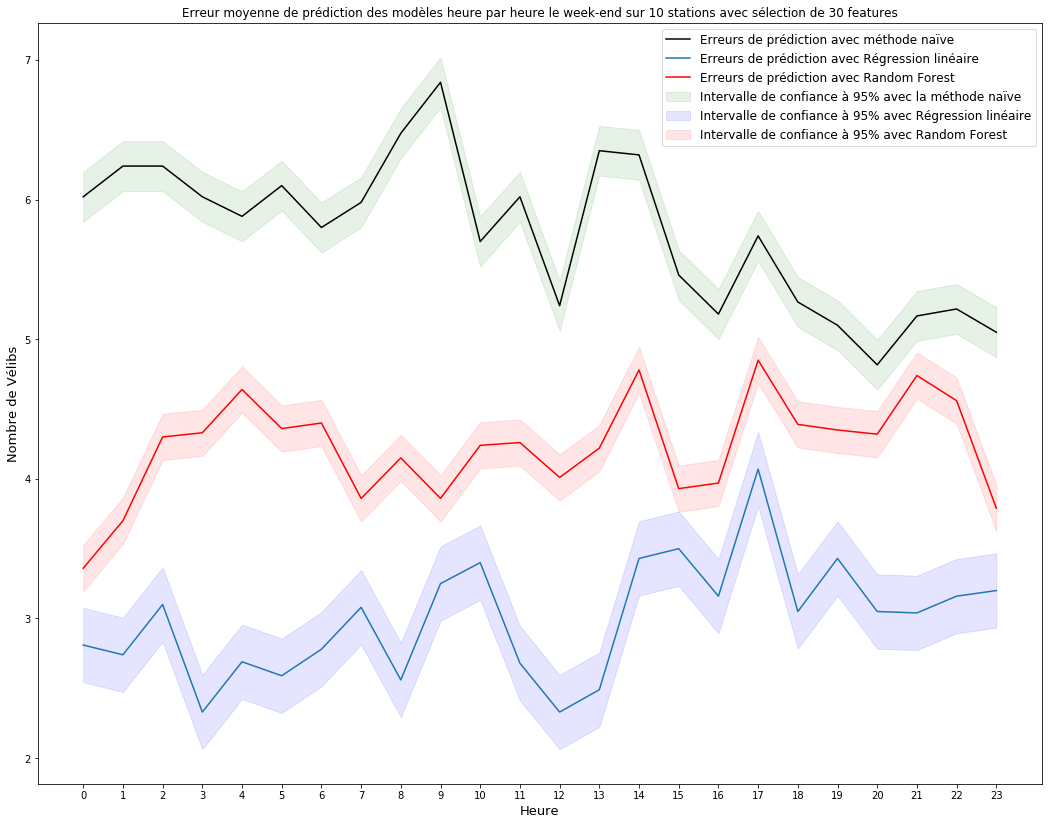

In [200]:
# Affichage des erreurs de prédiction

# Méthode naïve
x = mean_erreur_par_heure_choix_features_weekend.index
y0 = mean_erreur_par_heure_choix_features_weekend['erreur_pred_naif']
ci0_95 = 1.96 * np.std(y0)/np.mean(y0)
ci0_50 = 0.67 * np.std(y0)/np.mean(y0)

# Régression linéaire
y1 = erreur_pred_lr_h_par_h
ci1_95 = 1.96 * np.std(y1)/np.mean(y1)
ci1_50 = 0.67 * np.std(y1)/np.mean(y1)

# Random forest
y2 = erreur_pred_rf_h_par_h
ci2_95 = 1.96 * np.std(y2)/np.mean(y2)
ci2_50 = 0.67 * np.std(y2)/np.mean(y2)


fig, ax = plt.subplots(figsize=(18, 14))

# Plot Méthode naïve
ax.plot(x,y0, 'k', label = 'Erreurs de prédiction avec méthode naïve')
ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 95% avec la méthode naïve")
#ax.fill_between(x, (y0-ci0_50), (y0+ci0_50), color='r', alpha=.1)

# Plot Régression linéaire
ax.plot(x,y1, label = 'Erreurs de prédiction avec Régression linéaire')
ax.fill_between(x, (y1-ci1_95), (y1+ci1_95), color='b', alpha=.1, label = "Intervalle de confiance à 95% avec Régression linéaire")
#ax.fill_between(x, (y1-ci1_50), (y1+ci1_50), color='r', alpha=.1, label = "Intervalle de confiance à 50% - Régression linéaire")

# Plot Random forest
ax.plot(x,y2, color='r', label = 'Erreurs de prédiction avec Random Forest')
ax.fill_between(x, (y2-ci2_95), (y2+ci2_95), color='r', alpha=.1, label = "Intervalle de confiance à 95% avec Random Forest")
#ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 50% avec Random Forest")
plt.xlabel('Heure', fontsize = 13)
plt.ylabel('Nombre de Vélibs', fontsize = 13)
ax.xaxis.set_ticks(range(24))
ax.legend(prop = {'size': 12})
plt.title('Erreur moyenne de prédiction des modèles heure par heure le week-end sur 10 stations avec sélection de 30 features')




On remarque que la méthode naïve commet beaucoup d'heure en modélisant le nombre de Vélibs entre 9h et 9h59. Regardons de plus pres ce qu'il se passe dans une station particulière

In [202]:
erreur_pred_lr_h_par_h_station7 = [
    resultats_0h[stations_tests[7]][4], 
    resultats_1h[stations_tests[7]][4], 
    resultats_2h[stations_tests[7]][4], 
    resultats_3h[stations_tests[7]][4], 
    resultats_4h[stations_tests[7]][4], 
    resultats_5h[stations_tests[7]][4], 
    resultats_6h[stations_tests[7]][4], 
    resultats_7h[stations_tests[7]][4], 
    resultats_8h[stations_tests[7]][4], 
    resultats_9h[stations_tests[7]][4], 
    resultats_10h[stations_tests[7]][4], 
    resultats_11h[stations_tests[7]][4], 
    resultats_12h[stations_tests[7]][4], 
    resultats_13h[stations_tests[7]][4], 
    resultats_14h[stations_tests[7]][4], 
    resultats_15h[stations_tests[7]][4], 
    resultats_16h[stations_tests[7]][4], 
    resultats_17h[stations_tests[7]][4], 
    resultats_18h[stations_tests[7]][4], 
    resultats_19h[stations_tests[7]][4], 
    resultats_20h[stations_tests[7]][4], 
    resultats_21h[stations_tests[7]][4], 
    resultats_22h[stations_tests[7]][4], 
    resultats_23h[stations_tests[7]][4]
    ]

erreur_pred_rf_h_par_h_station7 = [
    resultats_0h[stations_tests[7]][6], 
    resultats_1h[stations_tests[7]][6], 
    resultats_2h[stations_tests[7]][6], 
    resultats_3h[stations_tests[7]][6], 
    resultats_4h[stations_tests[7]][6], 
    resultats_5h[stations_tests[7]][6], 
    resultats_6h[stations_tests[7]][6], 
    resultats_7h[stations_tests[7]][6], 
    resultats_8h[stations_tests[7]][6], 
    resultats_9h[stations_tests[7]][6], 
    resultats_10h[stations_tests[7]][6], 
    resultats_11h[stations_tests[7]][6], 
    resultats_12h[stations_tests[7]][6], 
    resultats_13h[stations_tests[7]][6], 
    resultats_14h[stations_tests[7]][6], 
    resultats_15h[stations_tests[7]][6], 
    resultats_16h[stations_tests[7]][6], 
    resultats_17h[stations_tests[7]][6], 
    resultats_18h[stations_tests[7]][6], 
    resultats_19h[stations_tests[7]][6], 
    resultats_20h[stations_tests[7]][6], 
    resultats_21h[stations_tests[7]][6], 
    resultats_22h[stations_tests[7]][6], 
    resultats_23h[stations_tests[7]][6]
    ]

erreur_pred_naif_h_par_h_station7 = [
    resultats_0h[stations_tests[7]][8], 
    resultats_1h[stations_tests[7]][8], 
    resultats_2h[stations_tests[7]][8], 
    resultats_3h[stations_tests[7]][8], 
    resultats_4h[stations_tests[7]][8], 
    resultats_5h[stations_tests[7]][8], 
    resultats_6h[stations_tests[7]][8], 
    resultats_7h[stations_tests[7]][8], 
    resultats_8h[stations_tests[7]][8], 
    resultats_9h[stations_tests[7]][8], 
    resultats_10h[stations_tests[7]][8], 
    resultats_11h[stations_tests[7]][8], 
    resultats_12h[stations_tests[7]][8], 
    resultats_13h[stations_tests[7]][8], 
    resultats_14h[stations_tests[7]][8], 
    resultats_15h[stations_tests[7]][8], 
    resultats_16h[stations_tests[7]][8], 
    resultats_17h[stations_tests[7]][8], 
    resultats_18h[stations_tests[7]][8], 
    resultats_19h[stations_tests[7]][8], 
    resultats_20h[stations_tests[7]][8], 
    resultats_21h[stations_tests[7]][8], 
    resultats_22h[stations_tests[7]][8], 
    resultats_23h[stations_tests[7]][8]
    ]

Text(0.5, 1.0, 'Erreur moyenne de prédictions du nombre de Vélibs heure par heure le week-end dans la station 7')

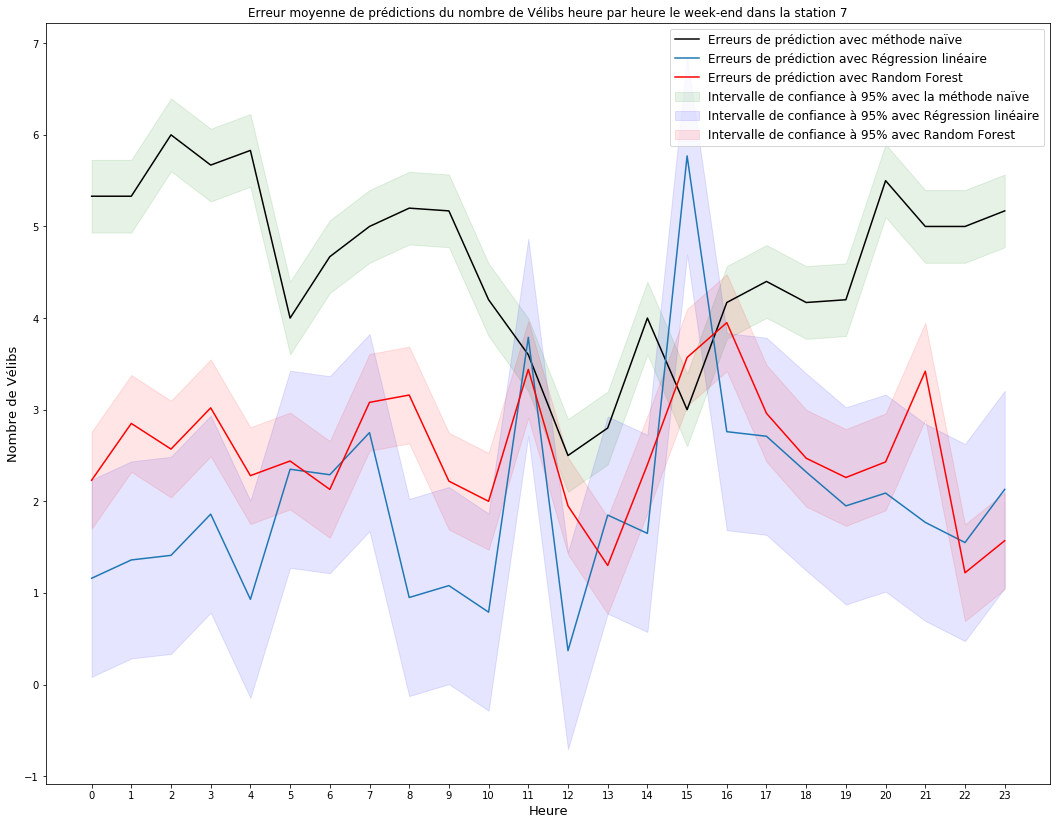

In [204]:
# Affichage des erreurs de prédiction

# Méthode naïve
x = mean_erreur_par_heure_choix_features_weekend.index
y0 = erreur_pred_naif_h_par_h_station7
ci0_95 = 1.96 * np.std(y0)/np.mean(y0)
ci0_50 = 0.67 * np.std(y0)/np.mean(y0)

# Régression linéaire
y1 = erreur_pred_lr_h_par_h_station7
ci1_95 = 1.96 * np.std(y1)/np.mean(y1)
ci1_50 = 0.67 * np.std(y1)/np.mean(y1)

# Random forest
y2 = erreur_pred_rf_h_par_h_station7
ci2_95 = 1.96 * np.std(y2)/np.mean(y2)
ci2_50 = 0.67 * np.std(y2)/np.mean(y2)


fig, ax = plt.subplots(figsize=(18, 14))

# Plot Méthode naïve
ax.plot(x,y0, 'k', label = 'Erreurs de prédiction avec méthode naïve')
ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 95% avec la méthode naïve")
#ax.fill_between(x, (y0-ci0_50), (y0+ci0_50), color='r', alpha=.1)

# Plot Régression linéaire
ax.plot(x,y1, label = 'Erreurs de prédiction avec Régression linéaire')
ax.fill_between(x, (y1-ci1_95), (y1+ci1_95), color='b', alpha=.1, label = "Intervalle de confiance à 95% avec Régression linéaire")
#ax.fill_between(x, (y1-ci1_50), (y1+ci1_50), color='r', alpha=.1, label = "Intervalle de confiance à 50% - Régression linéaire")

# Plot Random forest
ax.plot(x,y2, color='r', label = 'Erreurs de prédiction avec Random Forest')
ax.fill_between(x, (y2-ci2_95), (y2+ci2_95), color='r', alpha=.1, label = "Intervalle de confiance à 95% avec Random Forest")
#ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 50% avec Random Forest")
plt.xlabel('Heure', fontsize = 13)
plt.ylabel('Nombre de Vélibs', fontsize = 13)
ax.xaxis.set_ticks(range(24))
ax.legend(prop = {'size': 12})
plt.title('Erreur moyenne de prédictions du nombre de Vélibs heure par heure le week-end dans la station 7')




In [212]:
les_dfs_weekend_station7 = []
#for i in range(10):
df_week_end_station7 = resultats_choix_features_weekend[stations_tests[7]][1][7].copy()
df_week_end_station7 = pd.DataFrame(df_week_end_station7)
df_week_end_station7['nb_velibs'] = 0
df_week_end_station7['nb_velibs'] = df_week_end_station7[7]
del df_week_end_station7[7]
ajout_categorie(df_week_end_station7)
get_heure(df_week_end_station7)
#les_dfs_weekend_station7.append(df_week_end_station7)
#les_dfs_weekend_station7
#tous_les_dfs_weekend = pd.concat(les_dfs_weekend)
#tous_les_dfs_weekend
df_week_end_station7

,nb_velibs,categorie,heure
10/24/20;00:12:15,16,train,0
10/24/20;01:12:29,16,train,1
10/24/20;02:12:43,16,train,2
10/24/20;03:12:59,15,train,3
10/24/20;04:13:13,14,train,4
...,...,...,...
02/13/21;19:36:34,8,test,19
02/13/21;20:40:04,7,test,20
02/13/21;21:43:34,7,test,21
02/13/21;22:47:10,6,test,22


Text(0, 0.5, 'Nombre de vélos sur la période considérée')

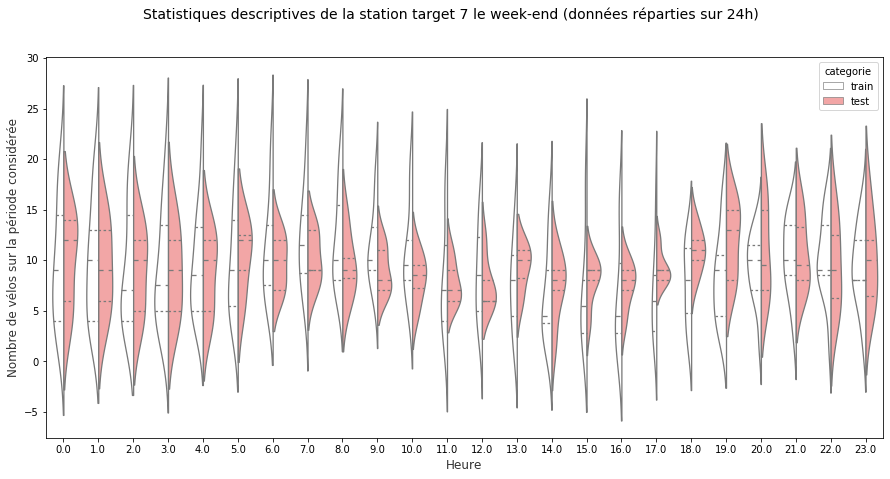

In [213]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
f.suptitle('Statistiques descriptives de la station target 7 le week-end (données réparties sur 24h)', fontsize=14)

sns.violinplot(x = 'heure', y = 'nb_velibs',data=df_week_end_station7, hue = 'categorie', split=True, inner='quart', linewidth=1.3, ax=ax, palette={'test': '#FF9999', 'train': 'white'})
ax.set_xlabel("Heure",size = 12,alpha=0.8)
ax.set_ylabel("Nombre de vélos sur la période considérée",size = 12,alpha=0.8)


In [254]:
fig=go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_lr_h_par_h_station7,
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_rf_h_par_h_station7,
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_naif_h_par_h_station7,
    name="Erreur moyenne avec la méthode naïve"     
))

fig.update_layout(
    autosize=False,
    width=1300,
    height=700,
    title="Data Visualisation de la station target 7",
    xaxis_title="Numéro de la station target",
    yaxis_title="Nombre de vélibs")


for i, categorie in enumerate(df_week_end_station7['categorie'].unique()):
    colors = ['rgb(253,180,98)','rgb(251,128,114)']

    df_plot=df_week_end_station7[df_week_end_station7['categorie']==categorie]

    fig.add_trace(go.Box(x=df_plot['heure'], y=df_plot['nb_velibs'], name = categorie, line=dict(color=colors[i])))#,
                         #notched=True))
fig.update_layout(boxmode='overlay', xaxis_tickangle=0)

fig.show()

In [205]:
erreur_pred_lr_h_par_h_station8 = [
    resultats_0h[stations_tests[8]][4], 
    resultats_1h[stations_tests[8]][4], 
    resultats_2h[stations_tests[8]][4], 
    resultats_3h[stations_tests[8]][4], 
    resultats_4h[stations_tests[8]][4], 
    resultats_5h[stations_tests[8]][4], 
    resultats_6h[stations_tests[8]][4], 
    resultats_7h[stations_tests[8]][4], 
    resultats_8h[stations_tests[8]][4], 
    resultats_9h[stations_tests[8]][4], 
    resultats_10h[stations_tests[8]][4], 
    resultats_11h[stations_tests[8]][4], 
    resultats_12h[stations_tests[8]][4], 
    resultats_13h[stations_tests[8]][4], 
    resultats_14h[stations_tests[8]][4], 
    resultats_15h[stations_tests[8]][4], 
    resultats_16h[stations_tests[8]][4], 
    resultats_17h[stations_tests[8]][4], 
    resultats_18h[stations_tests[8]][4], 
    resultats_19h[stations_tests[8]][4], 
    resultats_20h[stations_tests[8]][4], 
    resultats_21h[stations_tests[8]][4], 
    resultats_22h[stations_tests[8]][4], 
    resultats_23h[stations_tests[8]][4]
    ]

erreur_pred_rf_h_par_h_station8 = [
    resultats_0h[stations_tests[8]][6], 
    resultats_1h[stations_tests[8]][6], 
    resultats_2h[stations_tests[8]][6], 
    resultats_3h[stations_tests[8]][6], 
    resultats_4h[stations_tests[8]][6], 
    resultats_5h[stations_tests[8]][6], 
    resultats_6h[stations_tests[8]][6], 
    resultats_7h[stations_tests[8]][6], 
    resultats_8h[stations_tests[8]][6], 
    resultats_9h[stations_tests[8]][6], 
    resultats_10h[stations_tests[8]][6], 
    resultats_11h[stations_tests[8]][6], 
    resultats_12h[stations_tests[8]][6], 
    resultats_13h[stations_tests[8]][6], 
    resultats_14h[stations_tests[8]][6], 
    resultats_15h[stations_tests[8]][6], 
    resultats_16h[stations_tests[8]][6], 
    resultats_17h[stations_tests[8]][6], 
    resultats_18h[stations_tests[8]][6], 
    resultats_19h[stations_tests[8]][6], 
    resultats_20h[stations_tests[8]][6], 
    resultats_21h[stations_tests[8]][6], 
    resultats_22h[stations_tests[8]][6], 
    resultats_23h[stations_tests[8]][6]
    ]

erreur_pred_naif_h_par_h_station8 = [
    resultats_0h[stations_tests[8]][8], 
    resultats_1h[stations_tests[8]][8], 
    resultats_2h[stations_tests[8]][8], 
    resultats_3h[stations_tests[8]][8], 
    resultats_4h[stations_tests[8]][8], 
    resultats_5h[stations_tests[8]][8], 
    resultats_6h[stations_tests[8]][8], 
    resultats_7h[stations_tests[8]][8], 
    resultats_8h[stations_tests[8]][8], 
    resultats_9h[stations_tests[8]][8], 
    resultats_10h[stations_tests[8]][8], 
    resultats_11h[stations_tests[8]][8], 
    resultats_12h[stations_tests[8]][8], 
    resultats_13h[stations_tests[8]][8], 
    resultats_14h[stations_tests[8]][8], 
    resultats_15h[stations_tests[8]][8], 
    resultats_16h[stations_tests[8]][8], 
    resultats_17h[stations_tests[8]][8], 
    resultats_18h[stations_tests[8]][8], 
    resultats_19h[stations_tests[8]][8], 
    resultats_20h[stations_tests[8]][8], 
    resultats_21h[stations_tests[8]][8], 
    resultats_22h[stations_tests[8]][8], 
    resultats_23h[stations_tests[8]][8]
    ]

In [240]:
df_week_end_station8 = resultats_choix_features_weekend[stations_tests[8]][1][8].copy()
df_week_end_station8 = pd.DataFrame(df_week_end_station8)
df_week_end_station8['nb_velibs'] = 0
df_week_end_station8['nb_velibs'] = df_week_end_station8[8]
del df_week_end_station8[8]
ajout_categorie(df_week_end_station8)
get_heure(df_week_end_station8)

df_week_end_station8

,nb_velibs,categorie,heure
10/24/20;00:12:15,14,train,0
10/24/20;01:12:29,14,train,1
10/24/20;02:12:43,14,train,2
10/24/20;03:12:59,13,train,3
10/24/20;04:13:13,13,train,4
...,...,...,...
02/13/21;19:36:34,30,test,19
02/13/21;20:40:04,30,test,20
02/13/21;21:43:34,29,test,21
02/13/21;22:47:10,28,test,22


Text(0.5, 1.0, 'Erreur moyenne de prédictions du nombre de Vélibs heure par heure le week-end dans la station 8')

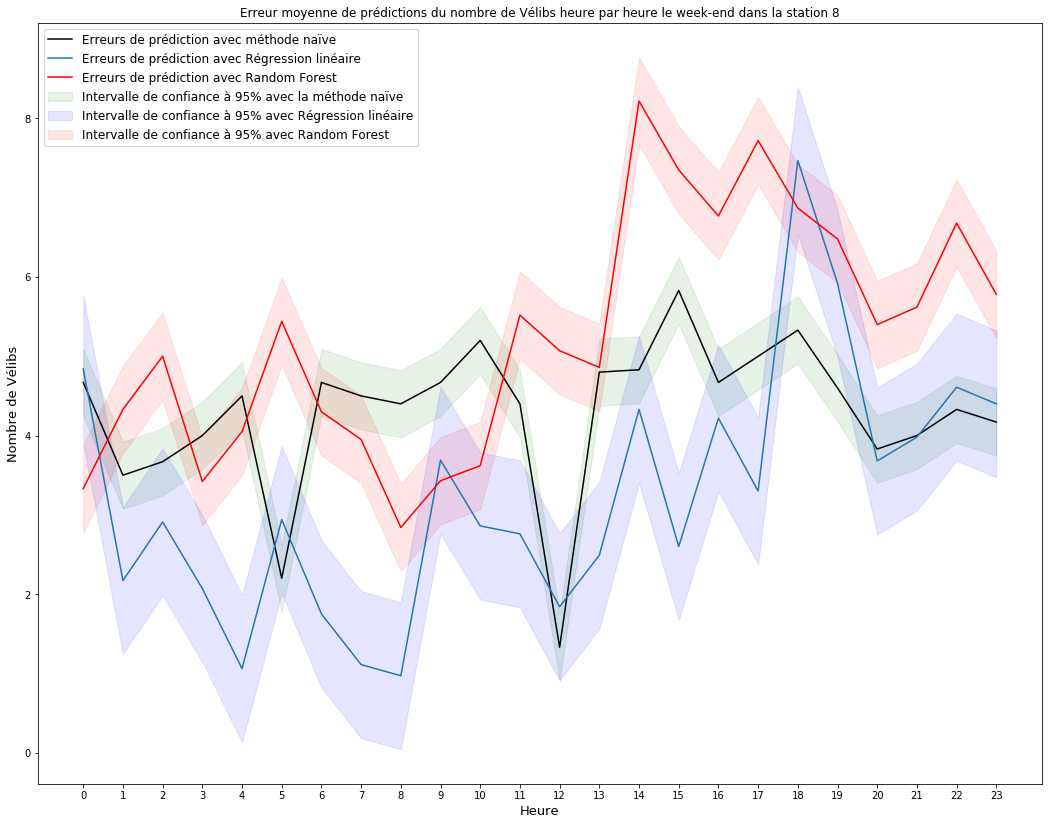

In [206]:
# Affichage des erreurs de prédiction

# Méthode naïve
x = mean_erreur_par_heure_choix_features_weekend.index
y0 = erreur_pred_naif_h_par_h_station8
ci0_95 = 1.96 * np.std(y0)/np.mean(y0)
ci0_50 = 0.67 * np.std(y0)/np.mean(y0)

# Régression linéaire
y1 = erreur_pred_lr_h_par_h_station8
ci1_95 = 1.96 * np.std(y1)/np.mean(y1)
ci1_50 = 0.67 * np.std(y1)/np.mean(y1)

# Random forest
y2 = erreur_pred_rf_h_par_h_station8
ci2_95 = 1.96 * np.std(y2)/np.mean(y2)
ci2_50 = 0.67 * np.std(y2)/np.mean(y2)


fig, ax = plt.subplots(figsize=(18, 14))

# Plot Méthode naïve
ax.plot(x,y0, 'k', label = 'Erreurs de prédiction avec méthode naïve')
ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 95% avec la méthode naïve")
#ax.fill_between(x, (y0-ci0_50), (y0+ci0_50), color='r', alpha=.1)

# Plot Régression linéaire
ax.plot(x,y1, label = 'Erreurs de prédiction avec Régression linéaire')
ax.fill_between(x, (y1-ci1_95), (y1+ci1_95), color='b', alpha=.1, label = "Intervalle de confiance à 95% avec Régression linéaire")
#ax.fill_between(x, (y1-ci1_50), (y1+ci1_50), color='r', alpha=.1, label = "Intervalle de confiance à 50% - Régression linéaire")

# Plot Random forest
ax.plot(x,y2, color='r', label = 'Erreurs de prédiction avec Random Forest')
ax.fill_between(x, (y2-ci2_95), (y2+ci2_95), color='r', alpha=.1, label = "Intervalle de confiance à 95% avec Random Forest")
#ax.fill_between(x, (y0-ci0_95), (y0+ci0_95), color='g', alpha=.1, label = "Intervalle de confiance à 50% avec Random Forest")
plt.xlabel('Heure', fontsize = 13)
plt.ylabel('Nombre de Vélibs', fontsize = 13)
ax.xaxis.set_ticks(range(24))
ax.legend(prop = {'size': 12})
plt.title('Erreur moyenne de prédictions du nombre de Vélibs heure par heure le week-end dans la station 8')




In [253]:
fig=go.Figure()

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_lr_h_par_h_station8,
    name="Erreur moyenne avec Régression Linéaire"      
))


fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_rf_h_par_h_station8,
    name="Erreur moyenne avec Forêt aléatoire"     
))

fig.add_trace(go.Scatter(
    x=mean_erreur_par_heure_choix_features_weekend.index,
    y=erreur_pred_naif_h_par_h_station8,
    name="Erreur moyenne avec la méthode naïve"     
))

fig.update_layout(
    autosize=False,
    width=1300,
    height=700,
    title="Data Visualisation de la station target 8",
    xaxis_title="Numéro de la station target",
    yaxis_title="Nombre de vélibs")


for i, categorie in enumerate(df_week_end_station8['categorie'].unique()):
    colors = ['rgb(253,180,98)','rgb(251,128,114)']

    df_plot=df_week_end_station7[df_week_end_station8['categorie']==categorie]

    fig.add_trace(go.Box(x=df_plot['heure'], y=df_plot['nb_velibs'], name = categorie, line=dict(color=colors[i])))#,
                         #notched=True))
fig.update_layout(boxmode='overlay', xaxis_tickangle=0)

fig.show()

In [248]:
print(px.colors.qualitative.Set3)

['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)', 'rgb(255,237,111)']
